In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing necessary Libraries

In [ ]:
import re
import numpy as np
import pandas as pd
import gzip
import json
import nltk
from nltk.corpus import stopwords
import random
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# ! pip install transformers
# ! pip install wordcloud
# !pip install pyabsa
nltk.download('vader_lexicon')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Data Preparation

In [ ]:
# for video game dataset

df_videogame_review = pd.read_json('/content/drive/MyDrive/reviews_Video_Games_5.json.gz',orient='records',lines = True)

In [ ]:
# for android app dataset

df_android_review = pd.read_json('/content/drive/MyDrive/reviews_Apps_for_Android_5.json.gz',orient='records',lines = True)

In [ ]:
df_android_review.head()

reviewerID        asin                   reviewerName helpful  \
0  A1N4O8VOJZTDVB  B004A9SDD8                 Annette Yancey  [1, 1]   
1  A2HQWU6HUKIEC7  B004A9SDD8        Audiobook lover "Kathy"  [0, 0]   
2  A1SXASF6GYG96I  B004A9SDD8                  Barbara Gibbs  [0, 0]   
3  A2B54P9ZDYH167  B004A9SDD8  Brooke Greenstreet "Babylove"  [3, 4]   
4   AFOFZDTX5UC6D  B004A9SDD8                     C. Galindo  [1, 1]   

                                          reviewText  overall  \
0  Loves the song, so he really couldn't wait to ...      3.0   
1  Oh, how my little grandson loves this app. He'...      5.0   
2  I found this at a perfect time since my daught...      5.0   
3  My 1 year old goes back to this game over and ...      5.0   
4  There are three different versions of the song...      5.0   

                                             summary  unixReviewTime  \
0                                        Really cute      1383350400   
1                                2-year-old loves it      1323043200   
2                                           Fun game      1337558400   
3                               We love our Monkeys!      1354752000   
4  This is my granddaughters favorite app on my K...      1391212800   

    reviewTime  
0   11 2, 2013  
1   12 5, 2011  
2  05 21, 2012  
3   12 6, 2012  
4   02 1, 2014

In [ ]:
df_videogame_review.head()

reviewerID        asin                        reviewerName  helpful  \
0  A2HD75EMZR8QLN  0700099867                                 123  [8, 12]   
1  A3UR8NLLY1ZHCX  0700099867  Alejandro Henao "Electronic Junky"   [0, 0]   
2  A1INA0F5CWW3J4  0700099867          Amazon Shopper "Mr.Repsol"   [0, 0]   
3  A1DLMTOTHQ4AST  0700099867                            ampgreen  [7, 10]   
4  A361M14PU2GUEG  0700099867        Angry Ryan "Ryan A. Forrest"   [2, 2]   

                                          reviewText  overall  \
0  Installing the game was a struggle (because of...      1.0   
1  If you like rally cars get this game you will ...      4.0   
2  1st shipment received a book instead of the ga...      1.0   
3  I got this version instead of the PS3 version,...      3.0   
4  I had Dirt 2 on Xbox 360 and it was an okay ga...      4.0   

                                           summary  unixReviewTime  \
0         Pay to unlock content? I don't think so.      1341792000   
1                                  Good rally game      1372550400   
2                                        Wrong key      1403913600   
3  awesome game, if it did not crash frequently !!      1315958400   
4                                           DIRT 3      1308009600   

    reviewTime  
0   07 9, 2012  
1  06 30, 2013  
2  06 28, 2014  
3  09 14, 2011  
4  06 14, 2011

### shape of the android data

In [ ]:
print("shape of the android app data: ",df_android_review.shape)
print("shape of the video game data: ",df_videogame_review.shape)

shape of the android app data:  (752937, 9)
shape of the video game data:  (231780, 9)


### datatypes of the columns


In [ ]:
print("for android app review")
print("----------------------------")
print(df_android_review.dtypes)
print('\n')

print("for video game review")
print("----------------------------")
print(df_videogame_review.dtypes)

for android app review
----------------------------
reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object


for video game review
----------------------------
reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object


### Checking null values


In [ ]:
print("Null values for android app review data")
print('----------------------------------------')
print(df_android_review.isnull().sum())

print('\n')

print("Null values for the video games review data")
print('--------------------------------------------')
print(df_videogame_review.isnull().sum())

Null values for android app review data
----------------------------------------
reviewerID            0
asin                  0
reviewerName      58198
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
dtype: int64


Null values for the video games review data
--------------------------------------------
reviewerID           0
asin                 0
reviewerName      2813
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64


### Renaming asin to product id


In [ ]:
df_android_review.rename(columns={'asin':'Product_id'},inplace=True)
df_videogame_review.rename(columns={'asin':'Product_id'},inplace=True)

In [ ]:
print(df_videogame_review.columns); print(df_android_review.columns)

Index(['reviewerID', 'Product_id', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')
Index(['reviewerID', 'Product_id', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')


### Dropping the nan values

In [ ]:
df_app = df_android_review.dropna()
df_video = df_videogame_review.dropna()

### Checking the null values

In [ ]:
df_app.isnull().sum()

reviewerID        0
Product_id        0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

In [ ]:
df_video.isnull().sum()

reviewerID        0
Product_id        0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

### Random sampling

#### we have used random sampling to simplify the data as we have more than 700000 rows so need to reduce our data and by random sampling it is reduced as nearly 70k rows


In [ ]:
android_data = df_app.sample(n=int(len(df_app)/10), replace=False, random_state=30)
print('Android_data shape: ',android_data.shape)
print('------------------')
games_Data = df_video.sample(n=int(len(df_video)/10), replace=False, random_state=30)
print('games_Data shape: ',games_Data.shape)

Android_data shape:  (69473, 9)
------------------
games_Data shape:  (22896, 9)


### Resetting the index after resampling to set the index of randomly selected data

In [ ]:
android_data = android_data.reset_index()
games_Data = games_Data.reset_index()

### Preprocessing of the text for sentiment analysis

In [ ]:
# function for removing punctuation,numbers present in the text data..

def clean_text(text):
  text = text.lower()
  text = re.sub("[^0-9A-Za-z\- ]+", " ", text)
  text = re.sub("(?<!\w)\d+", "", text)
  text = re.sub("-(?!\w)|(?<!\w)-", "", text)
  text = " ".join(text.split())
  text = text.lower()
  return text

In [ ]:
android_data['reviewText'][50000]

"It's fun to mess around with but I haven't really needed to use it much. It can be touchy at times, especially when trying to erase one of your inputs that you may have misplaced or that they app interpreted incorrectly."

### Applying clean_text function to review and summary for removing punctuation,numbers


In [ ]:
android_data['reviewText'] = android_data['reviewText'].apply(clean_text)
games_Data['reviewText'] = games_Data['reviewText'].apply(clean_text)
android_data['summary'] = android_data['summary'].apply(clean_text)
games_Data['summary'] = games_Data['summary'] .apply(clean_text)

In [ ]:
android_data['reviewText'][50000]

'it s fun to mess around with but i haven t really needed to use it much it can be touchy at times especially when trying to erase one of your inputs that you may have misplaced or that they app interpreted incorrectly'

### Removing stop words from the data


In [ ]:
stop = stopwords.words('english')
android_data['reviewText'] = android_data['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
games_Data['reviewText'] = games_Data['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
android_data['summary'] = android_data['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
games_Data['summary'] = games_Data['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
android_data['reviewText'][50000]

'fun mess around really needed use much touchy times especially trying erase one inputs may misplaced app interpreted incorrectly'

### lemmatization of the data


In [ ]:
android_data['reviewText'] = android_data['reviewText'].apply(lambda x: ' '.join([j.lemma_ for j in nlp(x)]))
games_Data['reviewText'] = games_Data['reviewText'].apply(lambda x: ' '.join([j.lemma_ for j in nlp(x)]))
android_data['summary'] = android_data['summary'].apply(lambda x: ' '.join([j.lemma_ for j in nlp(x)]))
games_Data['summary'] = games_Data['summary'].apply(lambda x: ' '.join([j.lemma_ for j in nlp(x)]))

In [ ]:
# lemmatized text
android_data['reviewText'][50000]

'fun mess around really need use much touchy time especially try erase one input may misplace app interpret incorrectly'

In [ ]:
android_data['summary'][50000]

'fun calculator'

### Converting our data to csv


In [ ]:
android_data.to_csv('android_data.csv')
games_Data.to_csv('games_data.csv')

### Reading the csv file

In [ ]:
android_df = pd.read_csv('/content/drive/MyDrive/capestone/android_data.csv')
games_df = pd.read_csv('/content/drive/MyDrive/capestone/games_data.csv')

FileNotFoundError: ignored

### Checking the shape of the data in csv file

In [ ]:
print(android_df.shape) #for android data

(69473, 11)


In [ ]:
print(games_df.shape) #for games data

(22896, 11)


## Exploratory Data Analysis (EDA)

### (1) Analysis for Video Games overall rating

In [ ]:
x = games_df["overall"].value_counts()          # Value counts of ratings in Video Game file
x

5.0    11911
4.0     5454
3.0     2764
1.0     1413
2.0     1354
Name: overall, dtype: int64

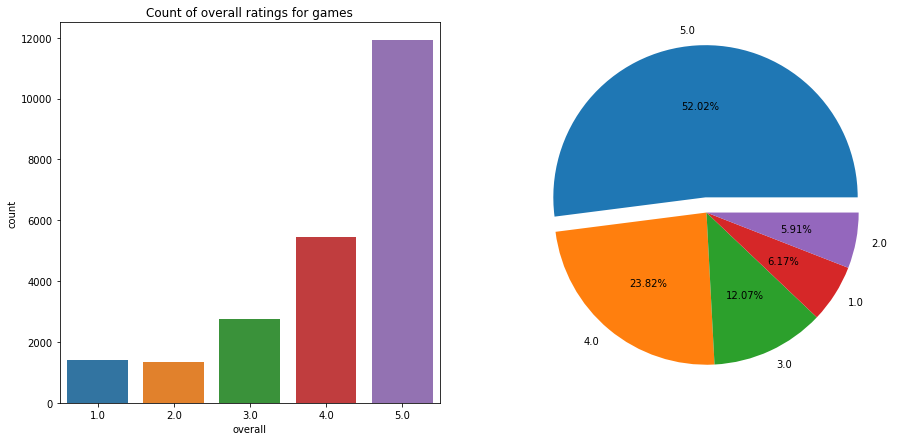

In [ ]:
import seaborn as sb
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].set_title("Count of overall ratings for games")
percentage = games_df["overall"].value_counts()
labels = list(games_df["overall"].value_counts().index)

sb.countplot(x = games_df["overall"], ax = ax[0])
plt.pie(percentage,labels = labels, autopct= "%0.2f%%",explode=[0.1,0.0,0.0,0.0,0.0])

plt.show()

* More than half of the population are highly satisfied with the product.

* Nearly 12% of the population is not satisfied with the product.

### 2. Analysis for Android App overall rating

In [ ]:
y = android_df["overall"].value_counts()                   #Counts of rating for android app file
y

5.0    35087
4.0    14586
3.0     8148
1.0     7379
2.0     4273
Name: overall, dtype: int64

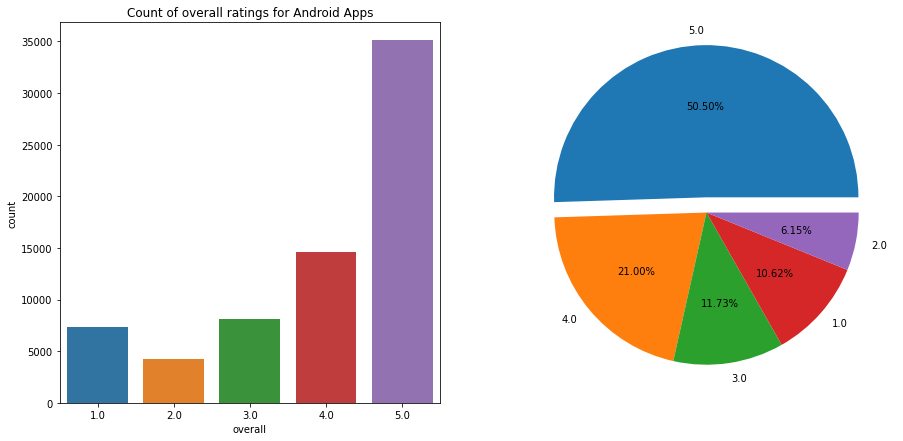

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].set_title("Count of overall ratings for Android Apps")
percentage = android_df["overall"].value_counts()
labels = list(android_df["overall"].value_counts().index)

sb.countplot(x = android_df["overall"], ax = ax[0])
plt.pie(percentage,labels = labels, autopct= "%0.2f%%",explode=[0.1,0.0,0.0,0.0,0.0])

plt.show()

* More than half of the population are highly satisfied with the app.

* Nearly 17% of the population is not satisfied with the product.

### 3. Analysis for Product-wise reviews of Video games

In [ ]:
games_product = games_df["Product_id"].value_counts()             #Count of products with ratings
games_product

B00BGA9WK2    83
B0015AARJI    77
B000B9RI14    60
B002VBWIP6    53
B0009VXBAQ    45
              ..
B000MQQ8R6     1
B000CBCVEK     1
B000V01UOO     1
B004CQRCF4     1
B0079NGSIY     1
Name: Product_id, Length: 7468, dtype: int64

Text(0.5, 1.0, 'Number of reviews per product for Android Apps')

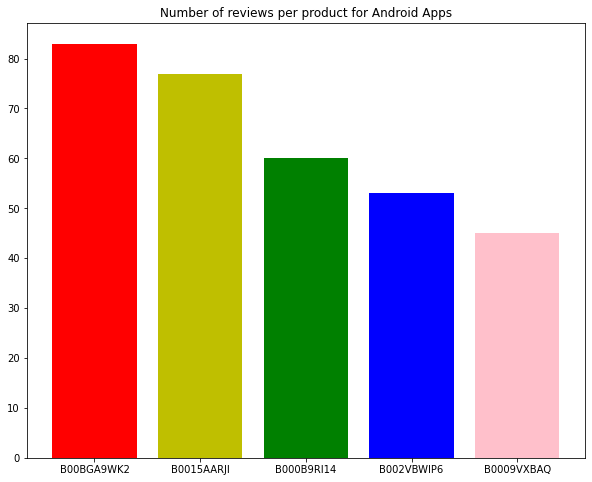

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(games_product.index[:5], games_product[:5],color=['r','y','g','b','pink'])
plt.title("Number of reviews per product for Android Apps")

* 83 reviews is the highest number of reviews which alloted to one product of video games.
* Above five games are most reviewed by people.

### 4. Analysis for Product-wise reviews of Android Apps

In [ ]:
app_product = android_df["Product_id"].value_counts()             #Count of products with ratings
app_product

B009UX2YAC    358
B0054JZC6E    357
B005ZXWMUS    334
B009HKL4B8    331
B00B2V66VS    296
             ... 
B005BNLRVC      1
B004V4O3V8      1
B00FDWKHRG      1
B004TNXGGE      1
B00BL8B5SG      1
Name: Product_id, Length: 9834, dtype: int64

Text(0.5, 1.0, 'Products with higher number of ratings for Video Games')

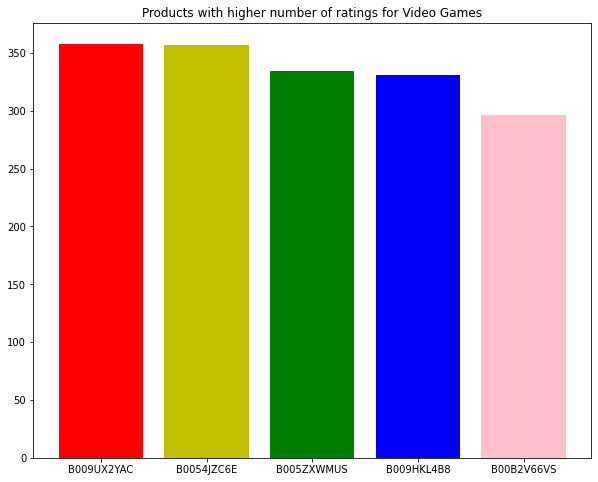

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(app_product.index[:5], app_product[:5],color=['r','y','g','b','pink'])
plt.title("Products with higher number of ratings for Video Games")

* 358 reviews is the highest number of reviews which alloted to one product of android apps.
* Above five apps are most reviewed by people.

# 2. Problem Statement 1: Sentiment Analysis

## Method:1 -  Vader Sentiment analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

### Example:-

In [ ]:
text = 'this product is not good'
analyzer1 = SentimentIntensityAnalyzer() # function is used from nltk library, it checks positive and negative words in the sentence
vs1 = analyzer1.polarity_scores(text) #it signifies that how data shows polarity
vs1

{'neg': 0.376, 'neu': 0.624, 'pos': 0.0, 'compound': -0.3412}

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

### VADER sentiment analysis for getting Compound score.


### Creating function for sentiment analysis


In [ ]:
def sentimental_Score(sentence):
  analyzer = SentimentIntensityAnalyzer()
  vs = analyzer.polarity_scores(sentence)
  score=vs['compound']
  if score >= 0.6:
    return 'very pos'
  elif (score < 0.6) and (score > 0.2):
    return 'positive'
  elif (score <= 0.2) and (score >= -0.2):
    return 'neu'
  elif (score < -0.2) and (score > -0.6):
    return 'negative'
  elif score <= -0.6:
    return 'very neg'

In [ ]:
android_df['reviewText'] = android_df['reviewText'].apply(str)
android_df['summary'] = android_df['summary'].apply(str)
games_df['reviewText'] = games_df['reviewText'].apply(str)
games_df['summary'] = games_df['summary'].apply(str)

### Applying vader sentiment analysis to review text and summary for two categories i.e. Android apps & Video games


In [ ]:
android_df['sentiment_reviewText'] = android_df['reviewText'].apply(lambda x: sentimental_Score(x))
android_df['sentiment_summaryText'] = android_df['summary'].apply(lambda x: sentimental_Score(x))
games_df['sentiment_reviewText'] = games_df['reviewText'].apply(lambda x: sentimental_Score(x))
games_df['sentiment_summaryText'] = games_df['summary'].apply(lambda x: sentimental_Score(x))

In [ ]:
android_df.head()

Unnamed: 0   index      reviewerID  Product_id reviewerName helpful  \
0           0   24959  A1MDQ9NHZBXQEW  B004LZOTHU        Hearn  [0, 0]   
1           1  192876   AZQ4DF43P6KD5  B006PH7WBM        Jared  [0, 1]   
2           2   82053  A13Q8F2PH26PAM  B00529IOXO      Vincent  [0, 0]   
3           3  361845  A20IHFYO0FK8JA  B008OOYALE     art girl  [0, 0]   
4           4  189524   AH0NVD5Z1D6WS  B006OOHVVC         Mark  [0, 0]   

                                          reviewText  overall         summary  \
0  instal application notice significant decrease...      3.0  battery killer   
1  precious princess fool spend almost digital ju...      1.0             rip   
2  app basic easy use send picture difficult neve...      4.0       great app   
3                  love wait egg hatch dragon evolve      4.0          review   
4  faotd despite crowded gb storage st gen kindle...      3.0     pretty good   

   unixReviewTime   reviewTime sentiment_reviewText sentiment_summaryText  
0      1316131200  09 16, 2011             very pos              very neg  
1      1334102400  04 11, 2012             positive                   neu  
2      1371513600  06 18, 2013             very pos              very pos  
3      1363996800  03 23, 2013             very pos                   neu  
4      1377043200  08 21, 2013                  neu              very pos

### Converting to csv


In [ ]:
android_df.to_csv('android_data with sentiments.csv')
games_df.to_csv('games_data with sentiments.csv')

### Reading the data from csv file

In [ ]:
android_df = pd.read_csv('/content/drive/MyDrive/android_data with sentiments.csv',parse_dates=['reviewText'])
games_df = pd.read_csv('/content/drive/MyDrive/games_data with sentiments.csv',parse_dates=['reviewText'])

In [ ]:
negative_android = android_df[(android_df['sentiment_reviewText']=='very neg')|(android_df['sentiment_reviewText']=='neg')]
negative_games = games_df[(games_df['sentiment_reviewText']=='very neg')|(games_df['sentiment_reviewText']=='neg')]

In [ ]:
negative_reviews_android = negative_android.reviewText.str.cat()
negative_reviews_android

'download even though intention play rating star irritate even also go get everyone know download rate star irritate shut stuff empty head pillah go cry nonexistent deity choice annoying d - bagok would think version minecraft right wrong stupid game bounce head one platform another actually real minecraft pocket edition check instead game stinkuse app less hour already sick every thirty second game stop ad come ask buy something gem gold chest game nauseate get old really fast interruption enough every twenty second tries connect facebook post minor achievement certain friend family want read quot brian learn tie shoe tribe quot twenty - seven time day game finally recover interruption get close facebook request pop atwitter request every single time many time refuse sign take hint game stop ask post review yeah gotcher review rightstart must miss thing hit dead end graphic good bit repetitiveknock star every time game cause kindle fire reboot include error txt message get try view ta

### word cloud for negative android reviews


Text(0.5, 1.0, 'Android apps negative review words')

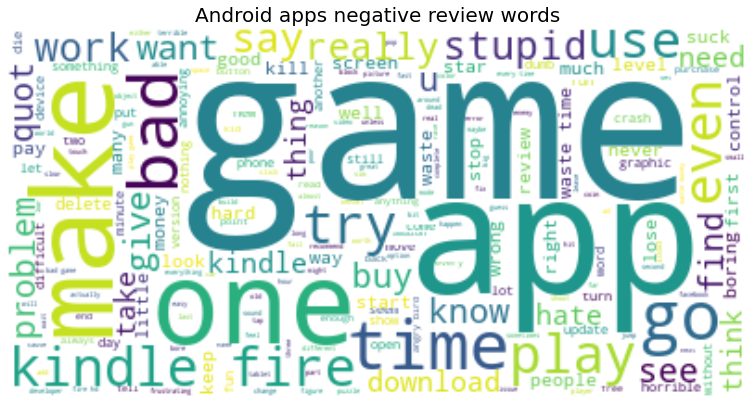

In [ ]:
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_android)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Android apps negative review words',fontsize=20)

### word cloud for negative video games reviews


In [ ]:
negative_reviews_games = negative_games.reviewText.str.cat()
negative_reviews_games

'worth price dollar really probably buck use gamestop really hate people try price thing old be not huge market video game call gamestop sell ps2 game wayy cheapfifteen year old son always check review actual gamer tube purchasing video game long waste money game end bottom collection never play times batman arkham video game still play every onecataclysm simply mind - blow experience homeworld year ago even today core gameplay tamper much grant cataclysm manage improve many aspect first game sum part add complete whole change make basic way play game first seem exciting battle quickly become tedious example technology tree add quot upgrade quot mean must take time fight search map outdated ship stop upgrade downright annoying also many new technology must micro - manage work unlink ship fire missle link attack missle run overall force micro - manage every battle instead concentrate big picture fight two seperate place usually mean lose place watch graphic engine improve well game hand

Text(0.5, 1.0, 'Video games negative review words')

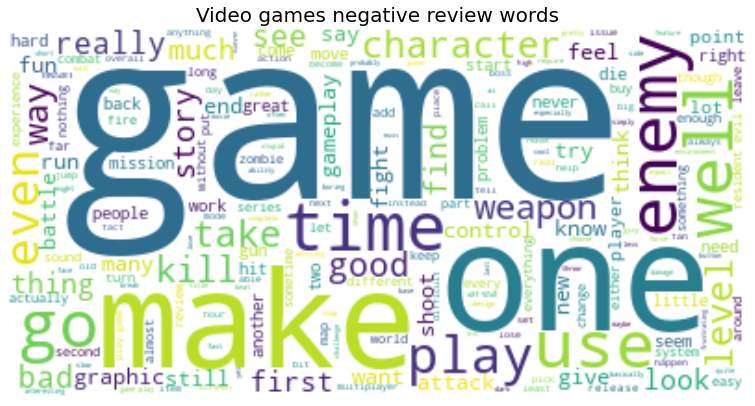

In [ ]:
# word cloud for negative video games reviews
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_games)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Video games negative review words',fontsize=20)

## Method:2 -  Bert sentiment classifier

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)
s_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


### Example:-

In [ ]:
s_analyzer('this product is bad')

[{'label': '1 star', 'score': 0.7642213702201843}]

In [ ]:
s_analyzer('this product is good but price was very high')

[{'label': '3 stars', 'score': 0.4948844313621521}]

### Defining the funcion for extracting the label

In [ ]:
def sentiment_score_bert(sentence):
  m = s_analyzer(sentence,truncation=True)
  for i in m:
    return i['label']

### Applying bert model to both dataframes


In [ ]:
games_df['sentiment_review_bert'] = games_df['reviewText'].apply(lambda j: sentiment_score_bert(j))
android_df['sentiment_review_bert'] = android_df['reviewText'].apply(lambda j: sentiment_score_bert(j))

In [ ]:
android_df.to_csv('android_final.csv')
games_df.to_csv('games_final.csv')

# Model comparison by confusion matrix
## we are comparing vader & bert model by plotting confusion matrix

### For games data

In [ ]:
games_final = pd.read_csv('/content/drive/MyDrive/games_data_final.csv') # bert result for games files

In [ ]:
games_final = games_final.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1'],axis=1) #dropping few columns from our data

In [ ]:
# vader class
games_final.loc[games_final['sentiment_reviewText']=='very pos','vader_class'] = 5.0
games_final.loc[games_final['sentiment_reviewText']=='positive','vader_class'] = 4.0
games_final.loc[games_final['sentiment_reviewText']=='neu','vader_class'] = 3.0
games_final.loc[games_final['sentiment_reviewText']=='negative','vader_class'] = 2.0
games_final.loc[games_final['sentiment_reviewText']=='very neg','vader_class'] = 1.0

In [ ]:
# bert class
games_final.loc[games_final['sentiment_review_bert']=='5 stars','bert_class'] = 5.0
games_final.loc[games_final['sentiment_review_bert']=='4 stars','bert_class'] = 4.0
games_final.loc[games_final['sentiment_review_bert']=='3 stars','bert_class'] = 3.0
games_final.loc[games_final['sentiment_review_bert']=='2 stars','bert_class'] = 2.0
games_final.loc[games_final['sentiment_review_bert']=='1 star','bert_class'] = 1.0

### confusion matrix for actual rating vs vader predicted class


In [ ]:
cm_vader = confusion_matrix(games_final['overall'],games_final['vader_class'],normalize='true')

### confusion matrix for actual rating vs bert predicted class


In [ ]:
cm_bert = confusion_matrix(games_final['overall'],games_final['bert_class'],normalize='true')

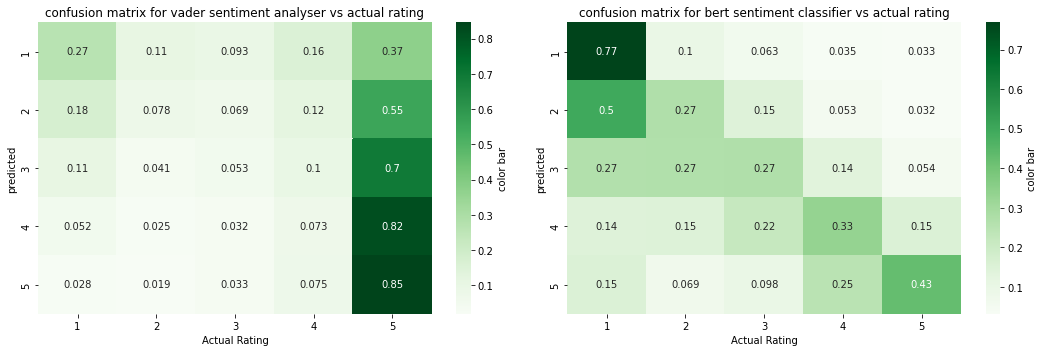

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.heatmap(cm_vader,cmap='Greens',annot=True,
            cbar_kws={'orientation':'vertical','label':'color bar'},
            xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])
plt.xlabel('Actual Rating')
plt.ylabel('predicted')
plt.title('confusion matrix for vader sentiment analyser vs actual rating')


plt.subplot(122)
sns.heatmap(cm_bert,cmap='Greens',annot=True,
            cbar_kws={'orientation':'vertical','label':'color bar'},
            xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])
plt.xlabel('Actual Rating')
plt.ylabel('predicted')
plt.title('confusion matrix for bert sentiment classifier vs actual rating')

plt.tight_layout()
plt.show()


* True positive rate is high for the bert model for all sentiments compared to vader sentiment analyser

####(1) Bert model is comparatively giving true positive results than vader analysis.

####(2) Vader model is giving False results by seeing in graphs that for  5-1ratings-> vader is giving 0.37 and bert is giving 0.033

### For android data

In [ ]:
android_final = pd.read_csv('/content/drive/MyDrive/android_df_final.csv')
android_final.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1'],axis=1,inplace=True)

In [ ]:
# vader class
android_final.loc[android_final['sentiment_reviewText']=='very pos','vader_class'] = 5.0
android_final.loc[android_final['sentiment_reviewText']=='positive','vader_class'] = 4.0
android_final.loc[android_final['sentiment_reviewText']=='neu','vader_class'] = 3.0
android_final.loc[android_final['sentiment_reviewText']=='negative','vader_class'] = 2.0
android_final.loc[android_final['sentiment_reviewText']=='very neg','vader_class'] = 1.0

# bert class
android_final.loc[android_final['sentiment_review_bert']=='5 stars','bert_class'] = 5.0
android_final.loc[android_final['sentiment_review_bert']=='4 stars','bert_class'] = 4.0
android_final.loc[android_final['sentiment_review_bert']=='3 stars','bert_class'] = 3.0
android_final.loc[android_final['sentiment_review_bert']=='2 stars','bert_class'] = 2.0
android_final.loc[android_final['sentiment_review_bert']=='1 star','bert_class'] = 1.0

### confusion matrix for actual rating vs vader predicted class


In [ ]:
cm_vader = confusion_matrix(android_final['overall'],android_final['vader_class'],normalize='true')

### confusion matrix for actual rating vs bert predicted class


In [ ]:
cm_bert = confusion_matrix(android_final['overall'],android_final['bert_class'],normalize='true')

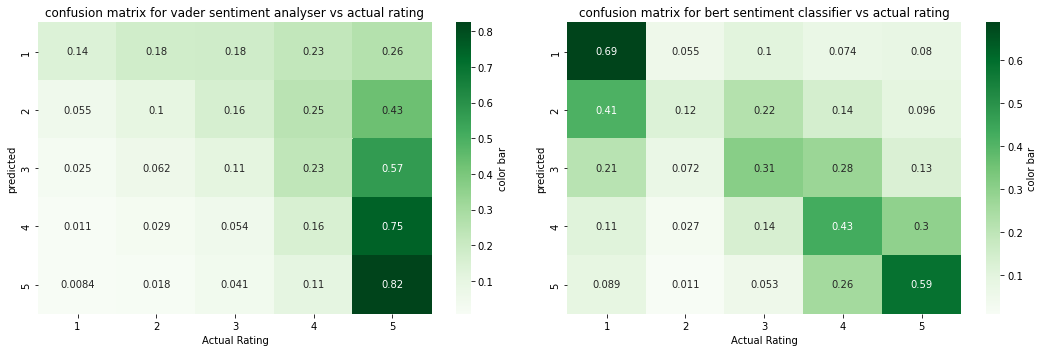

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.heatmap(cm_vader,cmap='Greens',annot=True,
            cbar_kws={'orientation':'vertical','label':'color bar'},
            xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])
plt.xlabel('Actual Rating')
plt.ylabel('predicted')
plt.title('confusion matrix for vader sentiment analyser vs actual rating')


plt.subplot(122)
sns.heatmap(cm_bert,cmap='Greens',annot=True,
            cbar_kws={'orientation':'vertical','label':'color bar'},
            xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])
plt.xlabel('Actual Rating')
plt.ylabel('predicted')
plt.title('confusion matrix for bert sentiment classifier vs actual rating')

plt.tight_layout()
plt.show()


####(1) Bert model is comparatively giving true positive results than vader analysis.

####(2) Vader model is giving False results by seeing in graphs that for  5-1ratings-> vader is giving 0.26 and bert is giving 0.08

## Reasons for negative sentiments

In [ ]:
!pip install pyabsa

In [ ]:
from pyabsa import available_checkpoints
checkpoint_map = available_checkpoints() #libraries

In [ ]:
from pyabsa import ATEPCCheckpointManager

aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True)  # False means load model on CPU

In [ ]:
# You can inference from a list of sentences or a DatasetItem from PyABSA
examples = ['Staff was very rude but food was delicious']
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

In [ ]:
atepc_result

[{'sentence': 'Staff was very rude but food was delicious',
  'IOB': ['B-ASP', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O'],
  'tokens': ['Staff',
   'was',
   'very',
   'rude',
   'but',
   'food',
   'was',
   'delicious'],
  'aspect': ['Staff', 'food'],
  'position': [[0, 5], [0, 5]],
  'sentiment': ['Negative', 'Positive'],
  'probs': [[0.9998047947883606,
    5.137383413966745e-05,
    0.00014384793757926673],
   [0.0004105722764506936, 3.9567938074469566e-05, 0.9995498061180115]],
  'confidence': [0.9998047947883606, 0.9995498061180115]}]

###Reasons for video games negative labels

In [ ]:
negative_game_df = games_df[(games_df['sentiment_review_bert'] == '1 star') | (games_df['sentiment_review_bert'] == '2 stars')]

In [ ]:
n = negative_game_df["Product_id"].value_counts()  # checking no. of reviews per product
npi = n[n.values > 5].index   # taking product ids of products having no. of reviews more than 5.

In [ ]:
examples = []                  #Step 1
for j in npi:      # considering one product at a time
  a = negative_game_df[negative_game_df['Product_id']==j]['reviewText']   # list of all reviews of one product
  for text in a:                   # considering one review at a time
    example = [text]               # text is each review in list format
    examples.append(example)       # examples contain reviews in list format

In [ ]:
aspects = []                                               #Step 2
sentiments = []
for example in examples:                                      #Each review text
  inference_source = example
  atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,
                            pred_sentiment=True,  # extracting the aspect terms and their sentiments
                            )

  for i in atepc_result:
    aspects.append(list(i.values())[list(i.keys()).index('aspect')])     #aspects contain aspect for each review
    sentiments.append( list(i.values())[list(i.keys()).index('sentiment')])  #Sentiments contains sentiments each review

In [ ]:
reasons = []
sentiment_reason = []
product_ids = []
for j in npi:                                           # selecting each product
  a = negative_game_df[negative_game_df['Product_id'] == j]['reviewText']
  for z,k in zip(a,range(len(sentiments))):
  #for k in range(len(sentiments)):
    for x in sentiments[k]: #  if a review contains -->   p n n [n][[n],[n]],
      if x == 'Negative':             # filter negative aspects only
        index = sentiments[k].index('Negative')         # finding the position of neg sentiment
        #print(index)
        #print(aspects[k][index])
        #print(j)
        reasons.append(aspects[k][index])              # reasons contain one aspect at a time
        sentiment_reason.append(sentiments[k][index])  # one sentiment at a time
        product_ids.append(j)                          # product id related to the same aspect
    #print("----------------------")                   # it will make duplicates

In [ ]:
reasons, sentiment_reason

In [ ]:
data = {'Product_id': product_ids, 'Reason': reasons, "sentiment":sentiment_reason}
product_id_games_df_r = pd.DataFrame(data)                                              # creating dataframe

In [ ]:
product_id_games_df_r.drop_duplicates(inplace = False).head(40)  # dropping duplicate cells

###Reasons for android apps negative labels


In [ ]:
negative_android_df = android_df[(android_df['sentiment_review_bert'] == '1 star') | (android_df['sentiment_review_bert'] == '2 stars')]

In [ ]:
m = negative_android_df["Product_id"].value_counts()
npia = m[m.values > 15].index

In [ ]:
examples_a = []
for j in npia:
  a = negative_android_df[negative_android_df['Product_id']==j]['reviewText']
  for text in a:
    example = [text]
    examples_a.append(example)

In [ ]:
aspects = []                                               #Step 2
sentiments = []
for example in examples_a:                                      #Each review text
  inference_source = example
  atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                            pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                            )

  for i in atepc_result:
    aspects.append(list(i.values())[list(i.keys()).index('aspect')])                          #aspects contain aspect for each review
    sentiments.append( list(i.values())[list(i.keys()).index('sentiment')])

In [ ]:
reasons = []
sentiment_reason = []
product_ids = []
for j in npia:                                           # selecting each product
  a = negative_android_df[negative_android_df['Product_id'] == j]['reviewText']
  for z,k in zip(a,range(len(sentiments))):
  #for k in range(len(sentiments)):
    for x in sentiments[k]: # p n n [n][[n],[n]]
      if x == 'Negative':
        index = sentiments[k].index('Negative')
        #print(index)
        #print(aspects[k][index])
        #print(j)
        reasons.append(aspects[k][index])                                         # reasons contain one aspect at a time
        sentiment_reason.append(sentiments[k][index])                             # one sentiment at a time
        product_ids.append(j)                                                     # product id related to the same aspect
    #print("----------------------")                                              # it will make duplicates

In [ ]:
data = {'Product_id': product_ids, 'Reason': reasons, "sentiment":sentiment_reason}
product_id_games_df_r = pd.DataFrame(data)                                              # creating dataframe

In [ ]:
product_id_games_df_r.drop_duplicates(inplace = False).head(40)  # dropping duplicate cells

In [ ]:
reasons_negative_android = pd.read_csv('/content/drive/MyDrive/capestone/Reasons for android final(in list form.csv')
reasons_negative_games = pd.read_csv('/content/drive/MyDrive/capestone/Reasons for games final.csv')


In [ ]:
reasons_negative_android.head(5)

Unnamed: 0  Product_id                                Reasons
0           0  B009HKL4B8             ['app', 'play', 'content']
1          24  B005ZXWMUS             ['app', 'play', 'content']
2          48  B0094BB4TW  ['app', 'return', 'external storage']
3          71  B008Y2FRFO                ['app', 'play', 'xbox']
4          91  B00E8KLWB4            ['app', 'kindle', 'action']

In [ ]:
reasons_negative_games.head(5)

Unnamed: 0  Product_id                            Reasons
0           0  B00BGA9WK2         ['graphic', 'ps4', 'size']
1          18  B00178630A         ['ps4', 'size', 'graphic']
2          35  B000B9RI14         ['ps4', 'size', 'graphic']
3          52  B0009VXBAQ         ['ps4', 'size', 'graphic']
4          69  B004FYEZMQ  ['ps4', 'size', 'console camera']

# Problem statement 2 - Finding the product names

* for video games data

In [ ]:
unique_product = games_final['Product_id'].value_counts()
unique_product[unique_product.values>5]

B00BGA9WK2    83
B0015AARJI    77
B000B9RI14    60
B002VBWIP6    53
B0009VXBAQ    45
              ..
B000K8YAKI     6
B000R3BNE2     6
B001UWGDC6     6
B00CMQTUY2     6
B0050SVGW8     6
Name: Product_id, Length: 910, dtype: int64

In [ ]:
product_idd = []
product_name = []
for j in unique_product[:911].index:
  a = games_final[games_final['Product_id'] == j]['reviewText']
  for i in a:
    str1 = nlp(i)
    for b in str1.ents:
      if b.label_=='PRODUCT':
        product_idd.append(j)
        product_name.append(b.text)

In [ ]:
d = {'Product_id':product_idd,"Product_name":product_name}
d1 = pd.DataFrame(d)
productnames = d1.groupby(by='Product_id')['Product_name'].agg(lambda x:x.value_counts().index[0])
productnames

Product_id
B00002DHEV       series4
B00002STEZ          dk64
B00002STGL       falcon2
B00004SQPD          sony
B00004SVV9        howard
                 ...    
B00C71034I      spoiler1
B00DC7G0GG    nsmb games
B00DC7G2W8          mk64
B00DC7O77A         dkctf
B00ERDGMT4         cons1
Name: Product_name, Length: 108, dtype: object

In [ ]:
product_game_name = pd.read_excel('/content/drive/MyDrive/capestone/Video_game_names.xlsx')
product_game_name

Product_id               Product_name
0   B00002STEZ                       dk64
1   B00005BOSF                   wavebird
2   B00005MO5G                   advance3
3   B0000696CZ                       gta3
4   B00006FWTX                   wavebird
5   B00007LV7Y                     konami
6   B00009ECGK                 stracraft2
7   B0000A1VER                nv40 nvidia
8   B00027CXEM           bastila kotor ii
9   B0009WPZOA                     bmw m3
10  B000B9RI14                  microsoft
11  B000FQ2D5E                       mk22
12  B000FQ2DTA                       ff13
13  B000FRVCAA                     bmw m3
14  B000OYMSL6                  microsoft
15  B000PS1HMM                       mp40
16  B000ZK695U                       ff13
17  B001CMIUYS                       ff13
18  B001TORSHO  bmw m3 short circuit game
19  B003ICGL7I                  dreadful2
20  B003JVKHEQ                    fairly2
21  B003O6JIVE                       ff13

* for Android app data

In [ ]:
product_name_android = pd.DataFrame(productnames)
product_name_android.to_csv('product_name_android.csv')

In [ ]:
unique_product1 = android_final['Product_id'].value_counts()
unique_product1[unique_product1.values>5]

B009UX2YAC    358
B0054JZC6E    357
B005ZXWMUS    334
B009HKL4B8    331
B00B2V66VS    296
             ... 
B008REEKRA      6
B00FTJB5QK      6
B004THM08K      6
B00DU860MG      6
B006CW7I00      6
Name: Product_id, Length: 2681, dtype: int64

In [ ]:
product_idd1 = []
product_name1 = []
for j in unique_product1[:2681].index:
  a = android_final[android_final['Product_id'] == j]['reviewText']
  for i in a:
    str1 = nlp(i)
    for b in str1.ents:
      if b.label_=='PRODUCT':
        product_idd1.append(j)
        product_name1.append(b.text)


In [ ]:
d2 = {'Product_id':product_idd1,"Product_name":product_name1}
d2 = pd.DataFrame(d2)
productnames1 = d2.groupby(by='Product_id')['Product_name'].agg(lambda x:x.value_counts().index[0])
productnames1

Product_id
B004FOA84A                     atlantis
B004N2NWT2                thrive tablet
B004SJ3AXI                         pg13
B004VSC7T4                     storage3
B004XJHBCE                        tf101
B0055S348W                       mg5320
B0058OE9CS                       flext9
B00594XOZU                          kik
B005GVF95O                       droid2
B005T87QCI                            l
B005XQLBU4                thrive tablet
B005ZFOOE8                   ten eleven
B005ZTFPFQ     atari shoot missile come
B0060QU5ZS                          til
B0066T8OH0                       tetris
B006OC2ANS                         cole
B006OCM0G0                        k x x
B0075AJ3O2          samsung tab hundred
B007693VXG                         yuck
B007FFZSE6                        k nmm
B007JPG04E                        zjjsk
B007MPJQ38                        tf101
B007T8LJM4                     atlantis
B0084HDG8Y                    supernova
B008GU42KK                   

In [ ]:
productnames1.to_csv('product_names_android1.csv')

In [ ]:
product_android_name = pd.read_excel('/content/drive/MyDrive/capestone/Android_app_names_verified.xlsx')
product_android_name

Product_id               Product_name
0   B004FOA84A                   atlantis
1   B004SJ3AXI                       pg13
2   B00594XOZU                        kik
3   B005XQLBU4              thrive tablet
4   B005ZFOOE8                 ten eleven
5   B005ZTFPFQ   atari shoot missile come
6   B0066T8OH0                     tetris
7   B006OC2ANS                       cole
8   B007693VXG                       yuck
9   B007T8LJM4                   atlantis
10  B0084HDG8Y                  supernova
11  B008GU42KK                   atlantis
12  B008HU2T9K                  azada one
13  B008JK6W5K   bmw mercedes - benz game
14  B008KYLSWW                    notifie
15  B00902AKK4                       xoom
16  B00910Y1OQ                   atlantis
17  B00964BWFS                   atlantis
18  B0098BGYM0                  discovery
19  B00A2RZDZI                      tf101
20  B00AB7IA1S  toranato fan glitche game
21  B00B99KJR0                   atlantis
22  B00BG3ID0Y                hooray coin
23  B00BO0C3DW                      tf101
24  B00CB2837W                     tetris
25  B00CGTNHXA                      work2
26  B00CHSPB8Y                     meteor
27  B00CZDSK7K                  families2
28  B00DLJ31HQ                     mosaic
29  B00E1GOGJK                   pic quiz
30  B00E1JZIGW                  discovery
31  B00ESNW58K                 strawberry
32  B00FAX6XQC          wimpy shotgun cal

# Problem-3 Future Data Trends

### Time series analysis for Android_df

In [ ]:
# changing the Datatype of reviewTime to datetime
android_final['reviewTime'] = pd.to_datetime(android_final['reviewTime'])
games_final['reviewTime'] = pd.to_datetime(games_final['reviewTime'])

In [ ]:
# formatting the dates
android_final['reviewTime'] = android_final['reviewTime'].dt.strftime('%m-%d-%Y')
games_final['reviewTime'] = games_final['reviewTime'].dt.strftime('%m-%d-%Y')


### Trend of positive sentiments

### Taking positive sentiments only (by bert method : ratings = 5 & 4)

In [ ]:
postive_android = android_final[(android_final['bert_class']==5.0)|(android_final['bert_class']==4.0)]

### Count of positive reviews per date

In [ ]:
review_positive = pd.DataFrame(postive_android.groupby(by='reviewTime')['bert_class'].count()).reset_index()

### Converting object datatype to datetime datatype

In [ ]:
review_positive['reviewTime'] = pd.to_datetime(review_positive['reviewTime'])

In [ ]:
pos_android = review_positive.sort_values(by='reviewTime',ascending=True)
pos_android = pos_android.set_index('reviewTime')

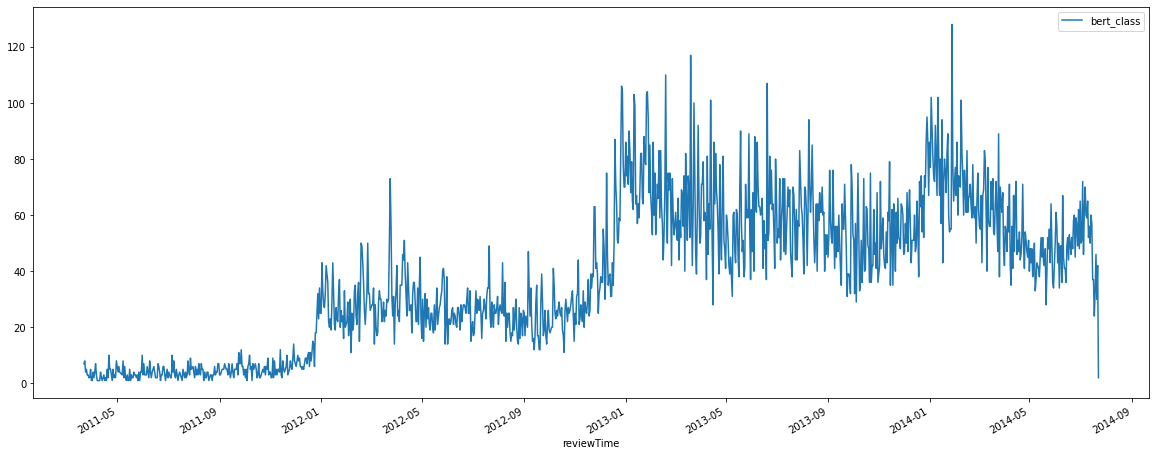

In [ ]:
pos_android.plot(figsize=(20,8))

In [ ]:
pos_android = pos_android.resample('w').sum() # Resampling the data Weekly

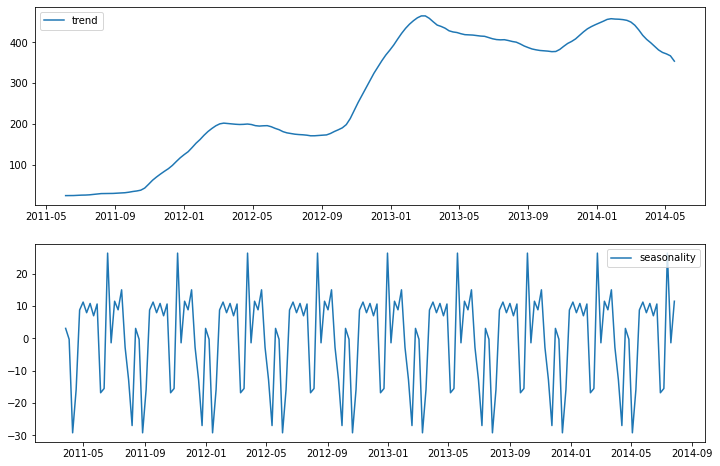

In [ ]:
#trend seasonality
decompose = seasonal_decompose(pos_android,period=20)

seasonality = decompose.seasonal
trend = decompose.trend

plt.subplots(figsize=(12,8))
plt.subplot(211)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(seasonality,label='seasonality')
plt.legend(loc='best')

plt.show()

* For positive sentiments :
* We have trend & seasonality both in our data.
* Since our data have seasonality, so we need to use SRIMA Model

### Stationarity

In [ ]:
def check_stationarity(data):
    pvalue = adfuller(data)[1]
    if pvalue < 0.05:
        ret ='data is stationary.proceed to modeling'
    else:
        ret ='data is not stationary.make it stationary'
    return(ret)

In [ ]:
check_stationarity(pos_android)

'data is not stationary.make it stationary'

* since our data is not stationary
* difference the data by 1

### Differencing the data

In [ ]:
diff_data = pos_android - pos_android.shift()
print(diff_data)

            bert_class
reviewTime            
2011-03-27         NaN
2011-04-03       -13.0
2011-04-10         0.0
2011-04-17        -2.0
2011-04-24        16.0
...                ...
2014-06-29        44.0
2014-07-06         5.0
2014-07-13        18.0
2014-07-20      -118.0
2014-07-27      -220.0

[175 rows x 1 columns]


In [ ]:
check_stationarity(diff_data.dropna())

'data is stationary.proceed to modeling'

In [ ]:
diff_data = diff_data.dropna()

In [ ]:
diff_data.isnull().sum()

bert_class    0
dtype: int64

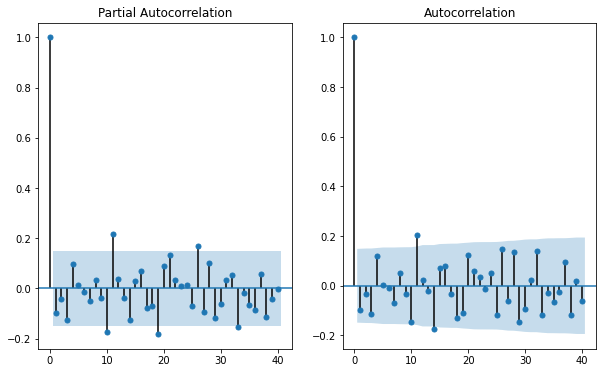

In [ ]:
#plot for acf and pacf

fig,ax=plt.subplots(1,2,figsize=(10,6))

plot_pacf(diff_data,lags=40,ax=ax[0])
plot_acf(diff_data,lags=40,ax=ax[1])      #default Confidence level is 95%

plt.show()

* p,d,q,=(5,2)

* Since our data has seasonality and trend present

In [ ]:
int(len(diff_data)*0.70)

121

### spillting the data into train and test (70% & 30%)


In [ ]:
rows = int(len(diff_data)*0.70)
train_data = diff_data[:rows]
test_data = diff_data[rows:]

#### Trying multiple combination of p & q values, taking values which have less error

In [ ]:
#taking (p,q) as (5,2)
p = np.arange(5)
q = np.arange(2)


p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
count=0

for i in p:
    for j in q:
            models.append(SARIMAX(train_data,order=(i,1,j),seasonal_order=(i,1,j,15)).fit())
            p_val.append(i)
            q_val.append(j)

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    mod.append(count)
    mse.append(mean_squared_error(test_data,pred))
    rmse.append(np.sqrt(mean_squared_error(test_data,pred)))
    count = count+1

    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')

In [ ]:
a = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})
a.sort_values(by='RMSE',ascending=True)

model  p  q          MSE       RMSE          AIC          BIC  \
0      0  0  1  2833.011870  53.226045  1132.661087  1140.622968   
2      2  1  1  2864.710470  53.522990  1132.160246  1145.430048   
6      6  3  1  3006.660493  54.833024  1134.803125  1158.688768   
8      8  4  1  3218.011521  56.727520  1135.388812  1164.582376   
4      4  2  1  3331.573408  57.719784  1130.735018  1149.312741   
7      7  4  0  3457.186628  58.797845  1140.702289  1164.587932   
5      5  3  0  3722.554231  61.012738  1144.277280  1162.855002   
3      3  2  0  4015.764415  63.370059  1166.695883  1179.965685   
1      1  1  0  5766.402620  75.936833  1202.514292  1210.476173   

               Ljung  
0  model is not good  
2      model is good  
6      model is good  
8      model is good  
4      model is good  
7      model is good  
5      model is good  
3      model is good  
1  model is not good

* Based on Low RMSE value, taking (p,q,d) = (1,1,1)

### SRIMA Model

In [ ]:
p=1; q=1; d=1
model = SARIMAX(train_data,order=(p,d,q),seasonal_order=(p,d,q,15)).fit()

In [ ]:
# Evaluating model performance
forcast_sarima=model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

In [ ]:
print(test_data.shape,forcast_sarima.shape)

(53, 1) (53,)


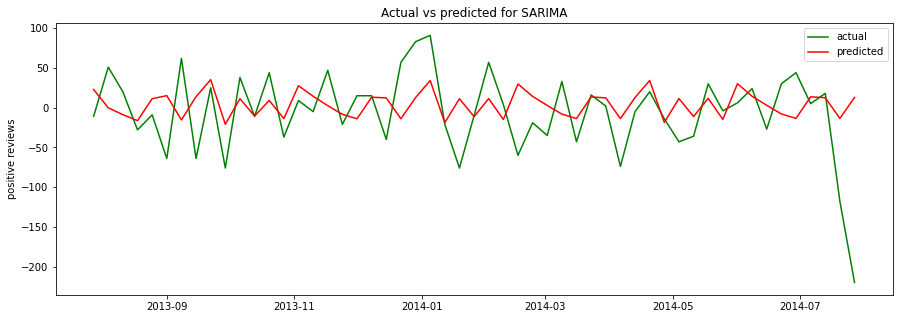

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_data,label='actual',c='g')
plt.plot(forcast_sarima,label='predicted',c='r')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('positive reviews')
plt.legend()
plt.show()

* Our Model is predicting nearly accurate values.




In [ ]:
#calculating mse,rmse
mse1 = mean_squared_error(test_data,forcast_sarima)
print("ARMA model 1. p={},q={} \n\tmse = {} \n\trmse = {}".format(p,q,mse1,np.sqrt(mse1)))

ARMA model 1. p=1,q=1 
	mse = 2864.710469568735 
	rmse = 53.522990103027084


In [ ]:
# future forcasting
future_forcast_sarima = model.predict(start=len(train_data), end=len(train_data)+len(test_data)+30)

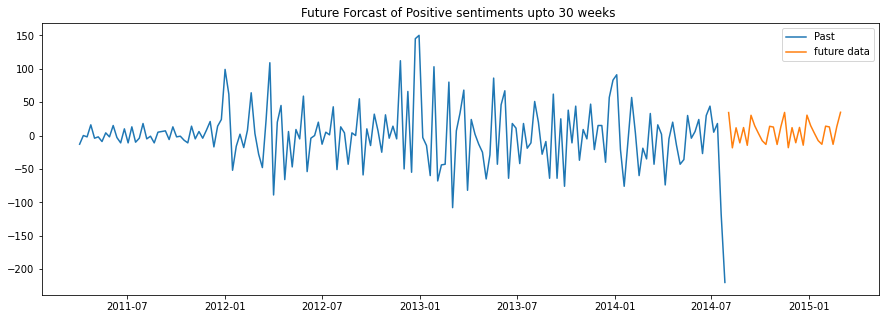

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(diff_data, label='Past')
plt.plot(future_forcast_sarima[-31:], label='future data')
plt.title('Future Forcast of Positive sentiments upto 30 weeks ')
plt.legend()
plt.show()

* After 2014, we cannot see not many flucations in our graph.
* Its showing similar trend as our past data is showing.

### Trend of Negative sentiment

In [ ]:
negative_android = android_final[(android_final['bert_class']==1.0)|(android_final['bert_class']==2.0)]
review_negative = pd.DataFrame(negative_android.groupby(by='reviewTime')['sentiment_reviewText'].count()).reset_index()
review_negative['reviewTime'] = pd.to_datetime(review_negative['reviewTime'])
neg_android = review_negative.sort_values(by='reviewTime',ascending=True)
neg_android = neg_android.set_index('reviewTime')


In [ ]:
#Resampling the data- weekly
neg_android = neg_android.resample('w').sum()

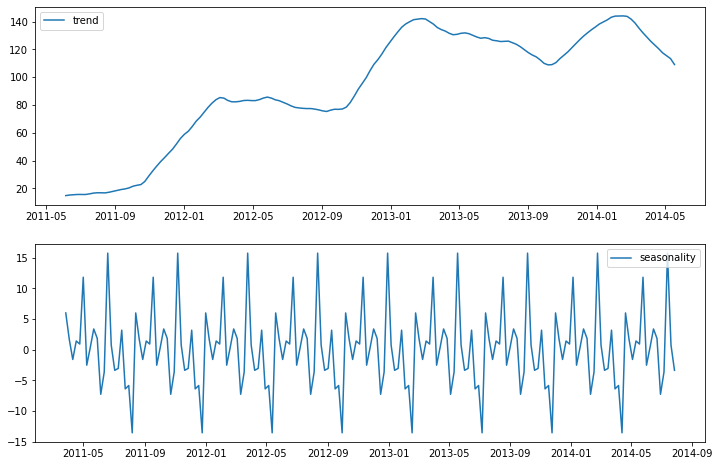

In [ ]:
#trend seasonality
decompose = seasonal_decompose(neg_android,period=20)

seasonality = decompose.seasonal
trend = decompose.trend

plt.subplots(figsize=(12,8))
plt.subplot(211)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(seasonality,label='seasonality')
plt.legend(loc='best')

plt.show()

* For negative sentiments :
* We have trend & seasonality both in our data.
* Since our data have seasonality, so we need to use SRIMA Model

In [ ]:
#stationarity checking
check_stationarity(neg_android)

'data is not stationary.make it stationary'

In [ ]:
# since our data is not stationary
# difference the data by 1
diff_data1 = neg_android - neg_android.shift()
print(diff_data1)

            sentiment_reviewText
reviewTime                      
2011-03-27                   NaN
2011-04-03                   5.0
2011-04-10                  -4.0
2011-04-17                  -2.0
2011-04-24                  13.0
...                          ...
2014-06-29                  -5.0
2014-07-06                  -3.0
2014-07-13                  45.0
2014-07-20                 -65.0
2014-07-27                 -59.0

[175 rows x 1 columns]


In [ ]:
check_stationarity(diff_data1.dropna())

'data is stationary.proceed to modeling'

In [ ]:
diff_data1 = diff_data1.dropna()

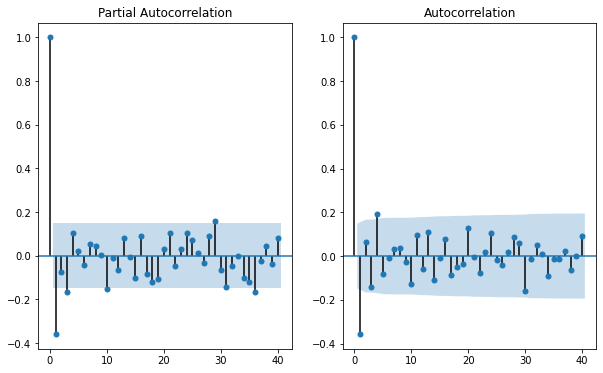

In [ ]:
#plot for acf and pacf

fig,ax=plt.subplots(1,2,figsize=(10,6))

plot_pacf(diff_data1,lags=40,ax=ax[0])
plot_acf(diff_data1,lags=40,ax=ax[1])      #default Confidence level is 95%

plt.show()

p,q = 5,2

In [ ]:
int(len(diff_data1)*0.70)

121

In [ ]:
# spillting the data into train and test
rows = int(len(diff_data1)*0.70)
train_data1 = diff_data1[:rows]
test_data1 = diff_data1[rows:]

In [ ]:
#taking (p,q) as (5,2)
p = np.arange(5)
q = np.arange(2)
d = 1

p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
count=0

for i in p:
    for j in q:
            models.append(SARIMAX(train_data1,order=(i,1,j),seasonal_order=(i,1,j,15)).fit())
            p_val.append(i)
            q_val.append(j)

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train_data1), end=len(train_data1)+len(test_data1)-1)
    mod.append(count)
    mse.append(mean_squared_error(test_data1,pred))
    rmse.append(np.sqrt(mean_squared_error(test_data1,pred)))
    count = count+1

    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')


In [ ]:
b = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})
b.sort_values(by='RMSE',ascending=True)


model  p  q          MSE       RMSE          AIC          BIC  \
4      4  2  1   413.004690  20.322517   953.310084   971.887807   
0      0  0  1   436.700634  20.897383   976.412325   984.374206   
2      2  1  1   459.640244  21.439222   953.161062   966.430864   
8      8  4  1   495.308739  22.255533   954.727459   983.921023   
6      6  3  1   535.773722  23.146786   951.438910   975.324553   
7      7  4  0   824.076939  28.706740   962.027188   985.912831   
5      5  3  0   978.905259  31.287462   967.773353   986.351075   
3      3  2  0  1380.774470  37.158774  1005.336439  1018.606241   
1      1  1  0  2037.599902  45.139782  1031.967094  1039.928975   

               Ljung  
4      model is good  
0  model is not good  
2      model is good  
8      model is good  
6      model is good  
7      model is good  
5      model is good  
3      model is good  
1  model is not good

* p,q selected based on the low rmse value

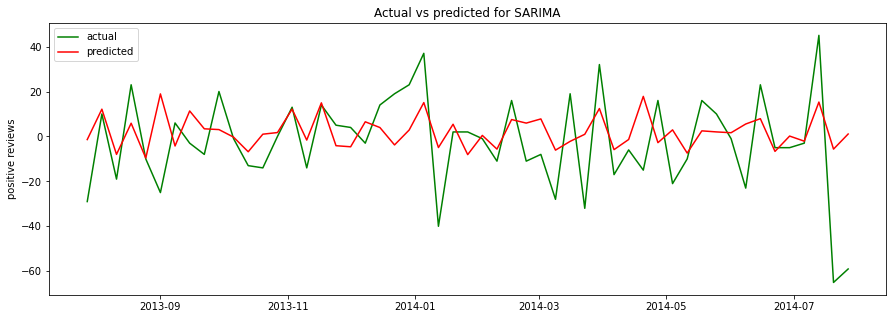

In [ ]:
# building model with low rmse model
p=2; q=1; d=1
model2 = SARIMAX(train_data1,order=(p,d,q),seasonal_order=(p,d,q,15)).fit()

# Evaluating model performance
forcast_sarima2 = model2.predict(start=len(train_data1), end=len(train_data1)+len(test_data1)-1)

plt.figure(figsize=(15,5))
plt.plot(test_data1,label='actual',c='g')
plt.plot(forcast_sarima2,label='predicted',c='r')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('positive reviews')
plt.legend()
plt.show()


* Our Model is predicting nearly accurate values.




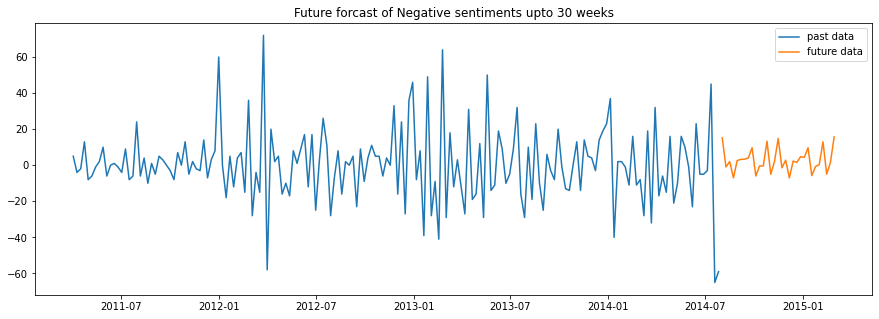

In [ ]:
# future forcasting
future_forcast_sarima2 = model2.predict(start=len(train_data1), end=len(train_data1)+len(test_data1)+30)
plt.figure(figsize=(15,5))
plt.plot(diff_data1,label='past data')
plt.plot(future_forcast_sarima2[-31:], label='future data')
plt.title('Future forcast of Negative sentiments upto 30 weeks')
plt.legend()
plt.show()

* Above Graph is showing negative sentiments of android.
* It is not showing many flucations,it is showing similar trend as our past data is showing.

### Trend of Neutral sentiment

In [ ]:
netural_android = android_final[(android_final['bert_class']== 3)]
review_netural = pd.DataFrame(netural_android.groupby(by='reviewTime')['sentiment_reviewText'].count()).reset_index()
review_netural['reviewTime'] = pd.to_datetime(review_netural['reviewTime'])
neu_android = review_netural.sort_values(by='reviewTime',ascending=True)
neu_android = neu_android.set_index('reviewTime')

### Resampling by weekly

In [ ]:
neu_android = neu_android.resample('w').sum()

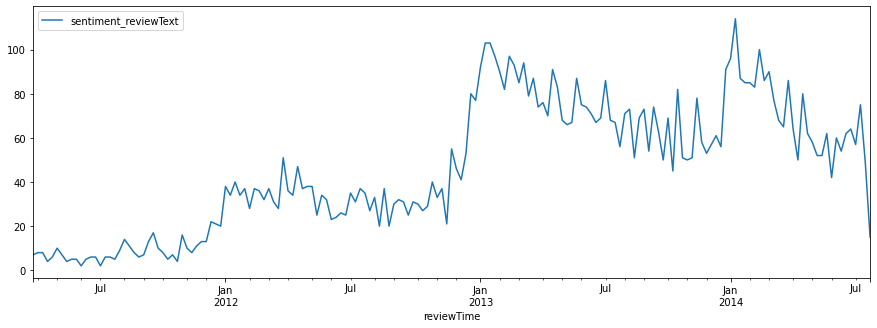

In [ ]:
neu_android.plot(figsize=(15,5))

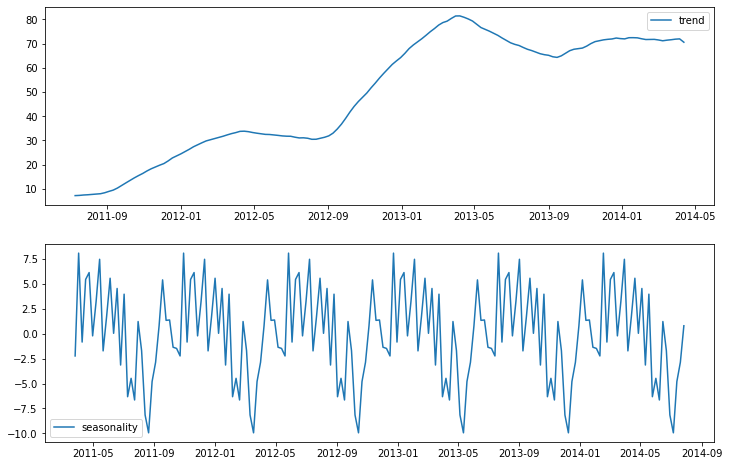

In [ ]:
#trend seasonality
decompose = seasonal_decompose(neu_android,period=30)

seasonality = decompose.seasonal
trend = decompose.trend

plt.subplots(figsize=(12,8))
plt.subplot(211)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(seasonality,label='seasonality')
plt.legend(loc='best')

plt.show()

* For neutral sentiments :
* We have trend & seasonality both in our data.
* Since our data have seasonality, so we need to use SRIMA Model

In [ ]:
#stationarity checking
check_stationarity(neu_android)

'data is not stationary.make it stationary'

In [ ]:
# since our data is not stationary
# difference the data by 1
diff_data2 = neu_android - neu_android.shift()
print(diff_data2)

            sentiment_reviewText
reviewTime                      
2011-03-27                   NaN
2011-04-03                   1.0
2011-04-10                   0.0
2011-04-17                  -4.0
2011-04-24                   2.0
...                          ...
2014-06-29                   2.0
2014-07-06                  -7.0
2014-07-13                  18.0
2014-07-20                 -26.0
2014-07-27                 -34.0

[175 rows x 1 columns]


In [ ]:
check_stationarity(diff_data2.dropna())

'data is stationary.proceed to modeling'

In [ ]:
diff_data2.dropna(inplace=True)

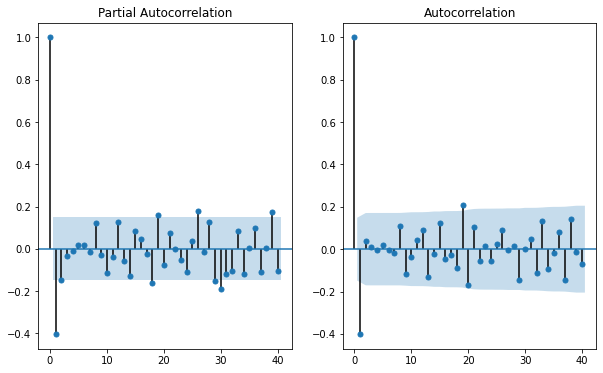

In [ ]:
#plot for acf and pacf

fig,ax=plt.subplots(1,2,figsize=(10,6))

plot_pacf(diff_data2,lags=40,ax=ax[0])
plot_acf(diff_data2,lags=40,ax=ax[1])      #default Confidence level is 95%

plt.show()

p,q = 6,2

In [ ]:
int(len(diff_data2)*0.70)

121

In [ ]:
# spillting the data into train and test
rows = int(len(diff_data2)*0.70)
train_data2 = diff_data2[:rows]
test_data2 = diff_data2[rows:]

In [ ]:
#taking (p,q) as (6,2)
p = np.arange(6)
q = np.arange(2)


p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
count=0

for i in p:
    for j in q:
            models.append(SARIMAX(train_data2,order=(i,1,j),seasonal_order=(i,1,j,15)).fit())
            p_val.append(i)
            q_val.append(j)

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train_data2), end=len(train_data2)+len(test_data2)-1)
    mod.append(count)
    mse.append(mean_squared_error(test_data2,pred))
    rmse.append(np.sqrt(mean_squared_error(test_data2,pred)))
    count = count+1

    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')

In [ ]:
c = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})
c.sort_values(by='RMSE',ascending=True)

model  p  q         MSE       RMSE         AIC         BIC  \
2       2  1  1  287.205630  16.947142  792.672055  805.941857   
0       0  0  1  289.291071  17.008559  804.399477  812.361358   
4       4  2  1  312.904538  17.689108  793.226437  811.804160   
6       6  3  1  314.482581  17.733657  797.197227  821.082871   
8       8  4  1  317.782981  17.826469  800.505250  829.698814   
7       7  4  0  320.823209  17.911538  808.981138  832.866781   
10     10  5  1  323.741773  17.992826  803.338721  837.840206   
5       5  3  0  339.530506  18.426354  817.636246  836.213969   
9       9  5  0  367.293392  19.164900  798.273585  827.467149   
3       3  2  0  373.702769  19.331393  832.872686  846.142488   
1       1  1  0  942.883866  30.706414  862.089971  870.051852   

                Ljung  
2       model is good  
0   model is not good  
4       model is good  
6       model is good  
8       model is good  
7       model is good  
10      model is good  
5       model is good  
9       model is good  
3       model is good  
1   model is not good

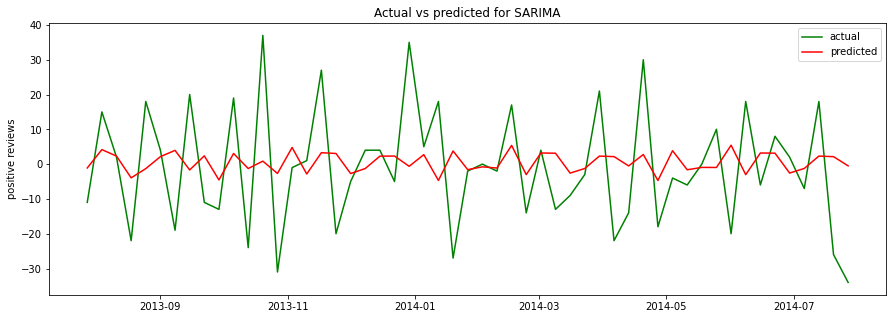

In [ ]:
# building model with low rmse model
p=1; q=1; d=1
model3 = SARIMAX(train_data2,order=(p,d,q),seasonal_order=(p,d,q,15)).fit()

# Evaluating model performance
forcast_sarima3 = model3.predict(start=len(train_data2), end=len(train_data2)+len(test_data2)-1)

plt.figure(figsize=(15,5))
plt.plot(test_data2,label='actual',c='g')
plt.plot(forcast_sarima3,label='predicted',c='r')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('positive reviews')
plt.legend()
plt.show()


* Our Model is predicting nearly accurate values.

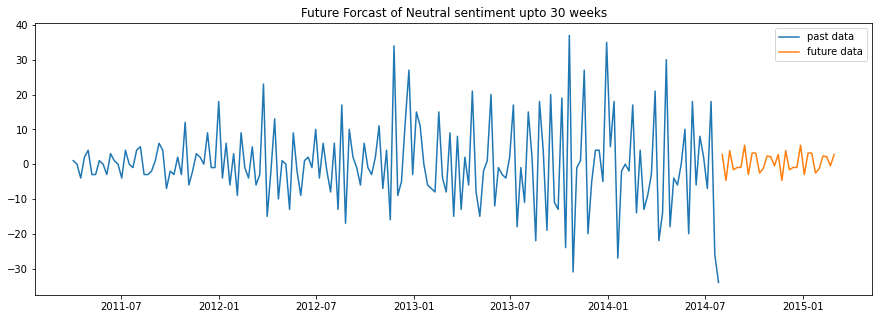

In [ ]:
# future forcasting
future_forcast_sarima3 = model3.predict(start=len(train_data2), end=len(train_data2)+len(test_data2)+30)
plt.figure(figsize=(15,5))
plt.plot(diff_data2, label='past data')
plt.plot(future_forcast_sarima3[-31:], label='future data')
plt.title('Future Forcast of Neutral sentiment upto 30 weeks')
plt.legend()
plt.show()

* Above Graph is showing Neutral sentiments of android.
* It is not showing many flucations,it is showing similar trend as our past data is showing.

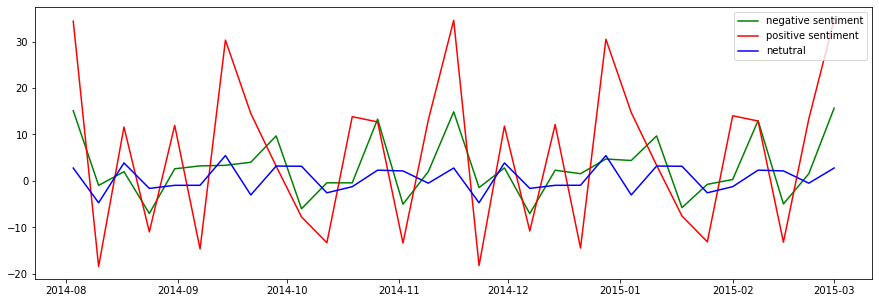

In [ ]:
# positive, negative and neutral comparision
plt.figure(figsize=(15,5))
plt.plot(future_forcast_sarima2[-31:],label='negative sentiment',c='g')
plt.plot(future_forcast_sarima[-31:],label = 'positive sentiment',c='r')
plt.plot(future_forcast_sarima3[-31:],label = 'netutral',c='b')
plt.legend()
plt.show()

* Positive sentiments have higher fluctuations than Negative & Neutral sentiments.
* Negative & Neutral sentiments is showing almost similar trend.


### Time series analysis for video games

### Trend for positive sentiments

In [ ]:
positive_games = games_final[(games_final['bert_class']==5.0)|(games_final['bert_class']==4.0)]
review_positive = pd.DataFrame(positive_games.groupby(by='reviewTime')['bert_class'].count()).reset_index()
review_positive['reviewTime'] = pd.to_datetime(review_positive['reviewTime'])
pos_games = review_positive.sort_values(by='reviewTime',ascending=True)
pos_games = pos_games.set_index('reviewTime')


In [ ]:
pos_games = pos_games.resample('w').sum()


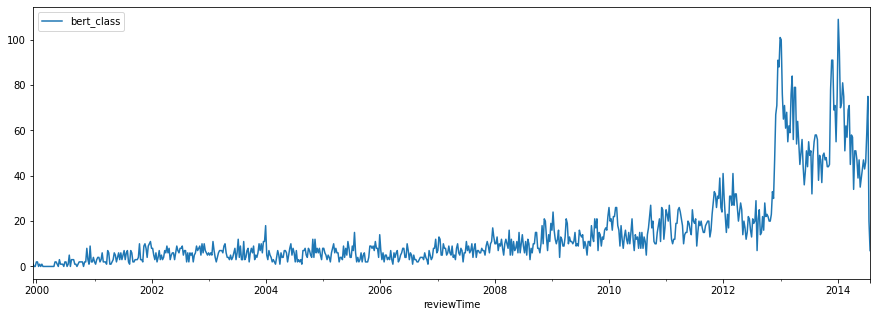

In [ ]:
pos_games.plot(figsize=(15,5))


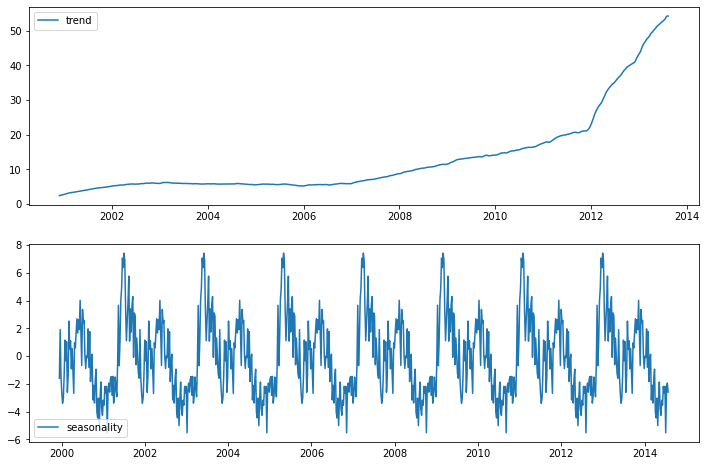

In [ ]:
#trend seasonality
decompose = seasonal_decompose(pos_games,period=100)

seasonality = decompose.seasonal
trend = decompose.trend

plt.subplots(figsize=(12,8))
plt.subplot(211)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(seasonality,label='seasonality')
plt.legend(loc='best')

plt.show()

* For positive sentiments :
* We have trend & seasonality both in our data.
* Since our data have seasonality, so we need to use SRIMA Model

In [ ]:
#stationarity checking
check_stationarity(pos_games)

'data is not stationary.make it stationary'

In [ ]:
# since our data is not stationary
# difference the data by 1
diff_data1 = pos_games - pos_games.shift()
print(diff_data1)

            bert_class
reviewTime            
1999-12-12         NaN
1999-12-19        -1.0
1999-12-26         0.0
2000-01-02         2.0
2000-01-09         0.0
...                ...
2014-06-29         3.0
2014-07-06        13.0
2014-07-13        16.0
2014-07-20       -55.0
2014-07-27       -13.0

[764 rows x 1 columns]


In [ ]:
check_stationarity(diff_data1.dropna())

'data is stationary.proceed to modeling'

In [ ]:
diff_data1.dropna(inplace=True)

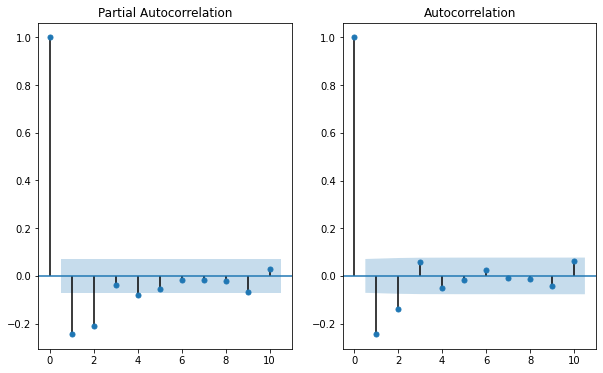

In [ ]:
#plot for acf and pacf

fig,ax=plt.subplots(1,2,figsize=(10,6))

plot_pacf(diff_data1,lags=10,ax=ax[0])
plot_acf(diff_data1,lags=10,ax=ax[1])      #default Confidence level is 95%

plt.show()

p,q = 4,2

In [ ]:
# spillting the data into train and test
rows = int(len(diff_data1)*0.70)
train_data = diff_data1[:rows]
test_data = diff_data1[rows:]

In [ ]:
#taking (p,q) as (4,2)
p = np.arange(4)
q = np.arange(2)


p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
count=0

for i in p:
    for j in q:
            models.append(SARIMAX(train_data,order=(i,1,j),seasonal_order=(i,1,j,15)).fit())
            p_val.append(i)
            q_val.append(j)

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    mod.append(count)
    mse.append(mean_squared_error(test_data,pred))
    rmse.append(np.sqrt(mean_squared_error(test_data,pred)))
    count = count+1

    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')

In [ ]:
q = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})
q.sort_values(by='RMSE',ascending=True)

model  p  q          MSE       RMSE          AIC          BIC  \
0      0  0  1   101.700068  10.084645  2890.842985  2903.592910   
2      2  1  1   102.535070  10.125960  2777.981708  2799.231585   
6      6  3  1   102.769201  10.137515  2724.114160  2762.363937   
4      4  2  1   102.801628  10.139114  2741.617792  2771.367619   
5      5  3  0   263.121170  16.221010  3011.129162  3040.878989   
3      3  2  0   279.406629  16.715461  3115.122342  3136.372218   
1      1  1  0  1009.922574  31.779279  3303.821178  3316.571104   

               Ljung  
0  model is not good  
2  model is not good  
6      model is good  
4      model is good  
5  model is not good  
3  model is not good  
1  model is not good

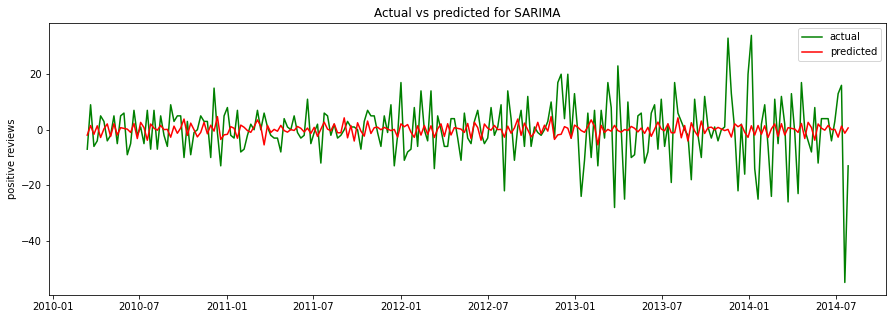

In [ ]:
# building model with low rmse model
p=0; q=1; d=1
model = SARIMAX(train_data,order=(p,d,q),seasonal_order=(p,d,q,100)).fit()

# Evaluating model performance
forcast_sarima = model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

plt.figure(figsize=(15,5))
plt.plot(test_data,label='actual',c='g')
plt.plot(forcast_sarima,label='predicted',c='r')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('positive reviews')
plt.legend()
plt.show()

* Our Model is predicting nearly accurate values.

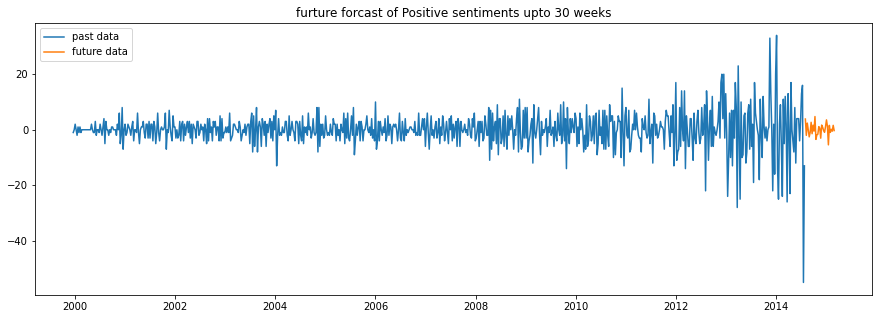

In [ ]:
# future forcasting
future_forcast_sarima = model.predict(start=len(train_data), end=len(train_data)+len(test_data)+30)
plt.figure(figsize=(15,5))
plt.plot(diff_data1,label='past data')
plt.plot(future_forcast_sarima[-31:],label='future data')
plt.title('furture forcast of Positive sentiments upto 30 weeks')
plt.legend()
plt.show()

* Above Graph is showing positive sentiments of android.
* It is showing many flucations,it is showing trend depending upon the past data.

### Trend for negative sentiments

In [ ]:
negative_games = games_final[(games_final['bert_class']==1.0)|(games_final['bert_class']==2.0)]
review_negative = pd.DataFrame(negative_games.groupby(by='reviewTime')['bert_class'].count()).reset_index()
review_negative['reviewTime'] = pd.to_datetime(review_negative['reviewTime'])
neg_games = review_negative.sort_values(by='reviewTime',ascending=True)
neg_games = neg_games.set_index('reviewTime')

In [ ]:
neg_games = neg_games.resample('w').sum()

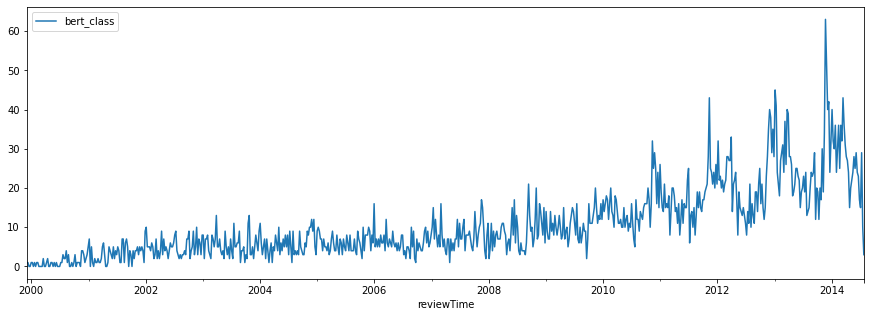

In [ ]:
neg_games.plot(figsize=(15,5))

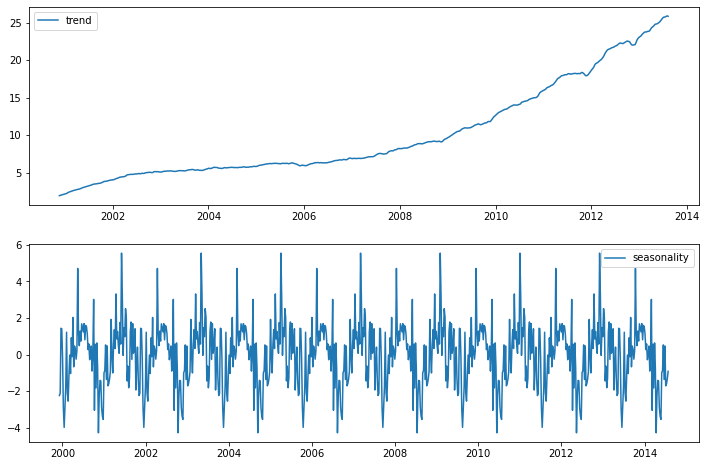

In [ ]:
#trend seasonality
decompose = seasonal_decompose(neg_games,period=100)

seasonality = decompose.seasonal
trend = decompose.trend

plt.subplots(figsize=(12,8))
plt.subplot(211)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(seasonality,label='seasonality')
plt.legend(loc='best')

plt.show()

* For negative sentiments :
* We have trend & seasonality both in our data.
* Since our data have seasonality, so we need to use SRIMA Model

In [ ]:
#stationarity checking
check_stationarity(neg_games)

'data is not stationary.make it stationary'

In [ ]:
# since our data is not stationary
# difference the data by 1
diff_data2 = neg_games - neg_games.shift()
print(diff_data2)

            bert_class
reviewTime            
1999-12-05         NaN
1999-12-12         0.0
1999-12-19        -1.0
1999-12-26         0.0
2000-01-02         1.0
...                ...
2014-06-29        -6.0
2014-07-06        -2.0
2014-07-13        14.0
2014-07-20       -19.0
2014-07-27        -7.0

[765 rows x 1 columns]


In [ ]:
check_stationarity(diff_data2.dropna())

'data is stationary.proceed to modeling'

In [ ]:
diff_data2.dropna(inplace=True)

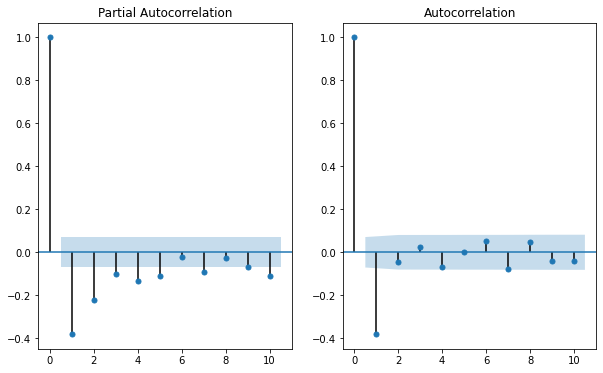

In [ ]:
#plot for acf and pacf

fig,ax=plt.subplots(1,2,figsize=(10,6))

plot_pacf(diff_data2,lags=10,ax=ax[0])
plot_acf(diff_data2,lags=10,ax=ax[1])      #default Confidence level is 95%

plt.show()

p,q = 7,2

In [ ]:
# spillting the data into train and test
rows = int(len(diff_data2)*0.70)
train_data1 = diff_data2[:rows]
test_data1 = diff_data2[rows:]

In [ ]:
#taking (p,q) as (7,2)
p = np.arange(4)
q = np.arange(2)


p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
count=0

for i in p:
    for j in q:
            models.append(SARIMAX(train_data1,order=(i,1,j),seasonal_order=(i,1,j,15)).fit())
            p_val.append(i)
            q_val.append(j)

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train_data1), end=len(train_data1)+len(test_data1)-1)
    mod.append(count)
    mse.append(mean_squared_error(test_data1,pred))
    rmse.append(np.sqrt(mean_squared_error(test_data1,pred)))
    count = count+1

    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')

In [ ]:
f = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})
f.sort_values(by='RMSE',ascending=True)

model  p  q         MSE       RMSE          AIC          BIC  \
0      0  0  1   49.531398   7.037855  2889.997683  2902.747608   
6      6  3  1   49.587175   7.041816  2710.634538  2748.884315   
2      2  1  1   49.609472   7.043399  2780.029100  2801.278976   
4      4  2  1   49.732835   7.052151  2729.786814  2759.536641   
5      5  3  0   53.736692   7.330532  3033.749721  3063.499548   
3      3  2  0   57.166176   7.560832  3135.413361  3156.663238   
1      1  1  0  156.724510  12.518966  3333.704087  3346.454013   

               Ljung  
0  model is not good  
6      model is good  
2  model is not good  
4      model is good  
5  model is not good  
3  model is not good  
1  model is not good

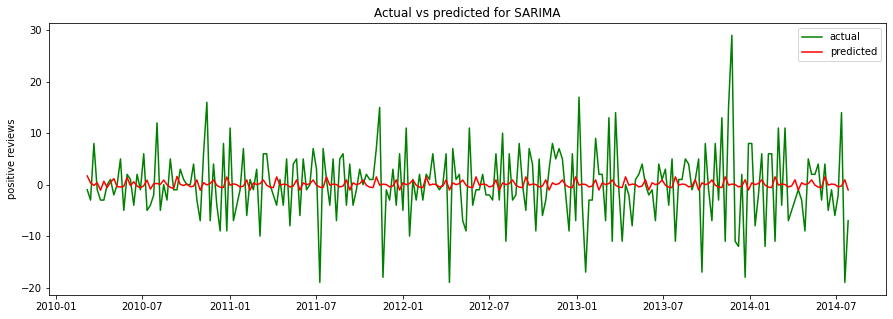

In [ ]:
# building model with low rmse model
p=3; q=1; d=1
model1 = SARIMAX(train_data1,order=(p,d,q),seasonal_order=(p,d,q,15)).fit()

# Evaluating model performance
forcast_sarima2 = model1.predict(start=len(train_data1), end=len(train_data1)+len(test_data1)-1)

plt.figure(figsize=(15,5))
plt.plot(test_data1,label='actual',c='g')
plt.plot(forcast_sarima2,label='predicted',c='r')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('positive reviews')
plt.legend()
plt.show()

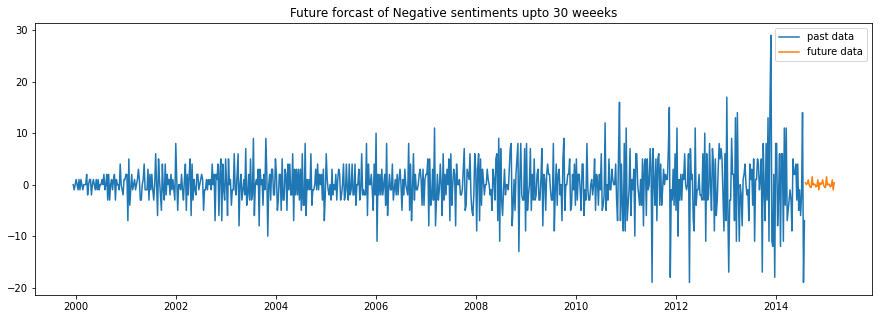

In [ ]:
# future forcasting
future_forcast_sarima1 = model1.predict(start=len(train_data1), end=len(train_data1)+len(test_data1)+30)
plt.figure(figsize=(15,5))
plt.plot(diff_data2,label='past data')
plt.plot(future_forcast_sarima1[-31:],label='future data')
plt.title('Future forcast of Negative sentiments upto 30 weeeks')
plt.legend()
plt.show()

* Above Graph is showing negative sentiments of android.
* It is showing many flucations,it is showing trend depending upon the past data.

### Trend for neutral sentiments

In [ ]:
neutral_games = games_final[games_final['bert_class']==3.0]
review_neutral = pd.DataFrame(neutral_games.groupby(by='reviewTime')['bert_class'].count()).reset_index()
review_neutral['reviewTime'] = pd.to_datetime(review_neutral['reviewTime'])
neu_games = review_neutral.sort_values(by='reviewTime',ascending=True)
neu_games = neu_games.set_index('reviewTime')

In [ ]:
neu_games = neu_games.resample('w').sum()

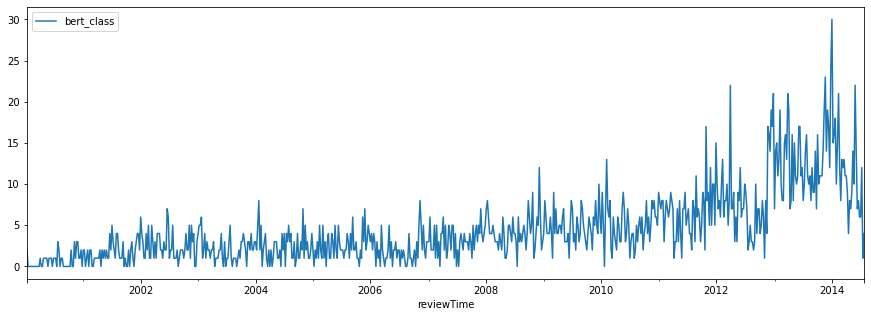

In [ ]:
neu_games.plot(figsize=(15,5))

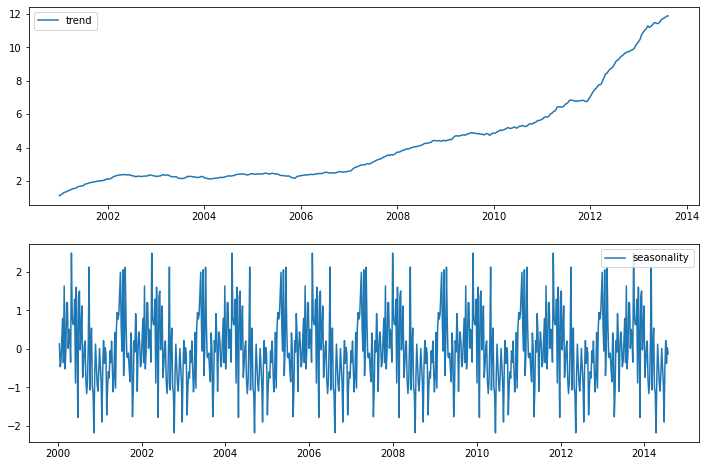

In [ ]:
#trend seasonality
decompose = seasonal_decompose(neu_games,period=100)

seasonality = decompose.seasonal
trend = decompose.trend

plt.subplots(figsize=(12,8))
plt.subplot(211)
plt.plot(trend,label='trend')
plt.legend(loc='best')

plt.subplot(212)
plt.plot(seasonality,label='seasonality')
plt.legend(loc='best')

plt.show()

* For neutral sentiments :
* We have trend & seasonality both in our data.
* Since our data have seasonality, so we need to use SRIMA Model

In [ ]:
#stationarity checking
check_stationarity(neu_games)

'data is not stationary.make it stationary'

In [ ]:
# since our data is not stationary
# difference the data by 1
diff_data3 = neu_games - neu_games.shift()
print(diff_data3)

            bert_class
reviewTime            
2000-01-16         NaN
2000-01-23        -2.0
2000-01-30         0.0
2000-02-06         0.0
2000-02-13         0.0
...                ...
2014-06-29        -2.0
2014-07-06         0.0
2014-07-13         6.0
2014-07-20       -11.0
2014-07-27         3.0

[759 rows x 1 columns]


In [ ]:
check_stationarity(diff_data3.dropna())

'data is stationary.proceed to modeling'

In [ ]:
diff_data3.dropna(inplace=True)

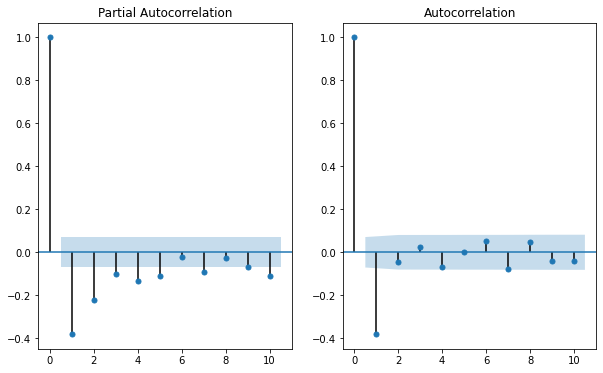

In [ ]:
#plot for acf and pacf

fig,ax=plt.subplots(1,2,figsize=(10,6))

plot_pacf(diff_data2,lags=10,ax=ax[0])
plot_acf(diff_data2,lags=10,ax=ax[1])      #default Confidence level is 95%

plt.show()

In [ ]:
# spillting the data into train and test
rows = int(len(diff_data3)*0.70)
train_data2 = diff_data3[:rows]
test_data2 = diff_data3[rows:]

In [ ]:
#taking (p,q) as (7,2)
p = np.arange(4)
q = np.arange(2)


p_val = []
q_val = []
models= []
rmse = []
mse = []
aic_val = []
bic_val = []
p_val = []
q_val = []
mod = []
Ljung = []
count=0

for i in p:
    for j in q:
            models.append(SARIMAX(train_data2,order=(i,1,j),seasonal_order=(i,1,j,15)).fit())
            p_val.append(i)
            q_val.append(j)

# for removing (p,q)(0,0)
m = models[1:]
p_v = p_val[1:]
q_v = q_val[1:]

for i in m:
    aic_val.append(i.aic)
    bic_val.append(i.bic)
    pred = i.predict(start=len(train_data2), end=len(train_data2)+len(test_data2)-1)
    mod.append(count)
    mse.append(mean_squared_error(test_data2,pred))
    rmse.append(np.sqrt(mean_squared_error(test_data2,pred)))
    count = count+1

    pvalue = (sm.stats.acorr_ljungbox(i.resid,lags=[1],return_df=True))['lb_pvalue'].values
    if pvalue < 0.05:
        Ljung.append('model is not good')
    else:
         Ljung.append('model is good')

In [ ]:
v = pd.DataFrame({'model':mod,"p":p_v,'q':q_v,"MSE":mse,"RMSE":rmse,"AIC":aic_val,"BIC":bic_val,'Ljung':Ljung})
v.sort_values(by='RMSE',ascending=True)

model  p  q         MSE       RMSE          AIC          BIC  \
6      6  3  1   22.152548   4.706649  2197.441192  2235.621202   
4      4  2  1   22.201152   4.711810  2219.155646  2248.851209   
2      2  1  1   22.269122   4.719017  2269.878302  2291.089419   
0      0  0  1   22.299114   4.722194  2383.224176  2395.950846   
5      5  3  0  140.657081  11.859894  2490.480914  2520.176476   
3      3  2  0  268.926425  16.398976  2602.801932  2624.013048   
1      1  1  0  411.521930  20.286003  2812.006748  2824.733418   

               Ljung  
6      model is good  
4      model is good  
2  model is not good  
0  model is not good  
5  model is not good  
3  model is not good  
1  model is not good

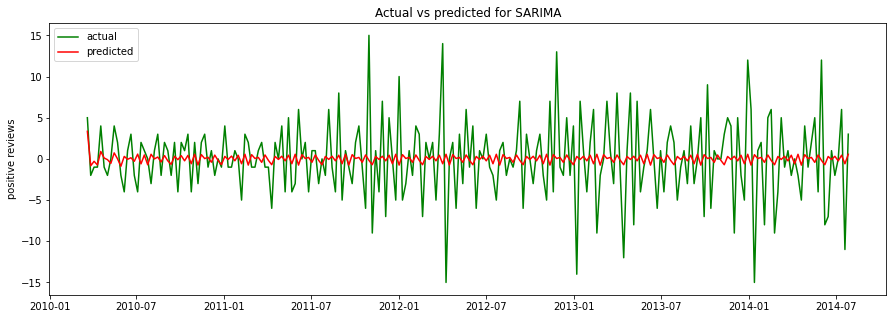

In [ ]:
# building model with low rmse model
p=3; q=1; d=1
model3 = SARIMAX(train_data2,order=(p,d,q),seasonal_order=(p,d,q,15)).fit()

# Evaluating model performance
forcast_sarima3 = model3.predict(start=len(train_data2), end=len(train_data2)+len(test_data2)-1)

plt.figure(figsize=(15,5))
plt.plot(test_data2,label='actual',c='g')
plt.plot(forcast_sarima3,label='predicted',c='r')
plt.title('Actual vs predicted for SARIMA')
plt.ylabel('positive reviews')
plt.legend()
plt.show()

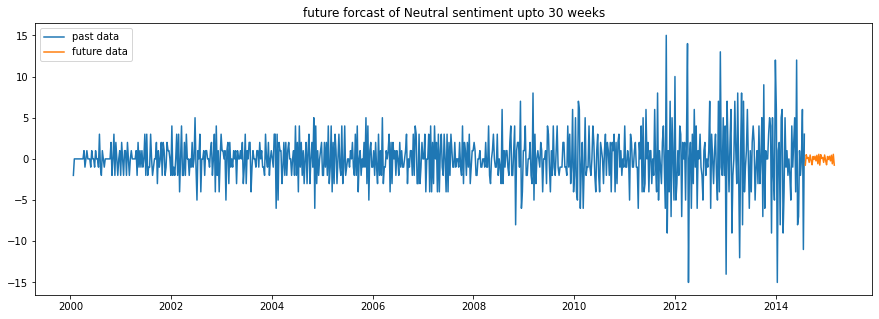

In [ ]:
# future forcasting
future_forcast_sarima2 = model3.predict(start=len(train_data2), end=len(train_data2)+len(test_data2)+30)
plt.figure(figsize=(15,5))
plt.plot(diff_data3,label='past data')
plt.plot(future_forcast_sarima2[-31:],label='future data')
plt.title('future forcast of Neutral sentiment upto 30 weeks')
plt.legend()
plt.show()

* Above Graph is showing neutral sentiments of android.
* It is showing many flucations,it is showing trend depending upon the past data.

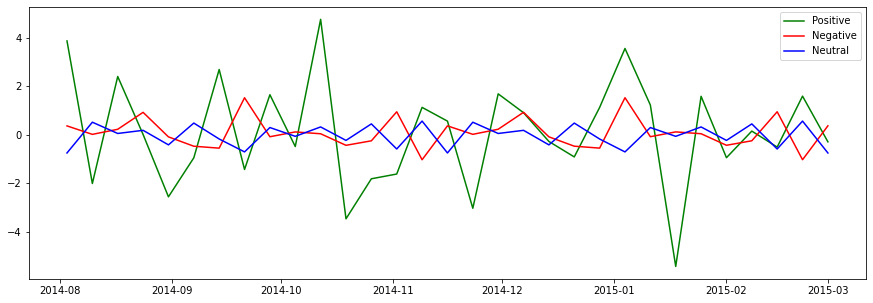

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(future_forcast_sarima[-31:], label='Positive', c='g')
plt.plot(future_forcast_sarima1[-31:], label='Negative', c='r')
plt.plot(future_forcast_sarima2[-31:], label='Neutral', c='b')
plt.legend()
plt.show()

* Positive sentiments data have more fluctuations compartively to others.
* Negative & Neutral data almost showing similar behaviour.

# problem 4-Inter category analysis (relation between two categories)

In [ ]:
android_df['reviewTime'] = pd.to_datetime(android_df['reviewTime']) #converted to datatime format

In [ ]:
pf = android_df[['reviewTime','sentiment_reviewText']] #taking review time & sentiment review time

In [ ]:
pf['reviewTime'] = pf['reviewTime'].dt.year #date time format

In [ ]:
pf.rename(columns={'sentiment_reviewText':'sentiment_reviewText_android'},inplace=True) #renaming the column name

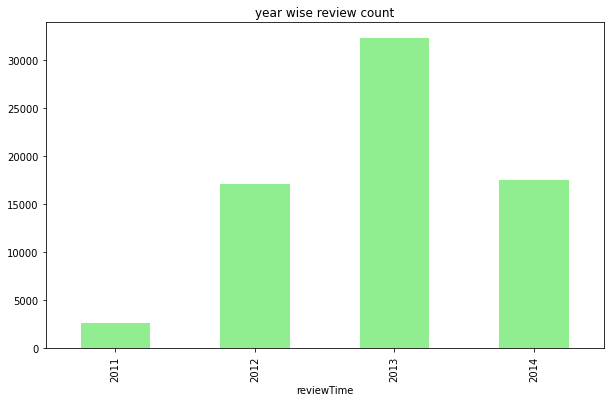

In [ ]:
pf.groupby(pf['reviewTime'])['sentiment_reviewText_android'].count().plot(kind='bar', figsize=(10,6),color='lightgreen')
plt.title('year wise review count')
plt.show()

* In 2013, 30000 plus reviews were given, maximum reviews count
* Least in 2011, minimum reviews count

In [ ]:
games_df['reviewTime'] = pd.to_datetime(games_df['reviewTime'])
gf = games_df[['reviewTime','sentiment_reviewText']]
gf['reviewTime'] = gf['reviewTime'].dt.year

In [ ]:
gf.rename(columns={'sentiment_reviewText':'sentiment_reviewText_games'},inplace=True)

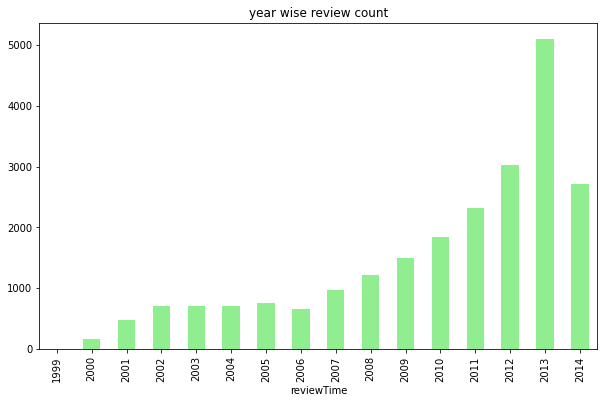

In [ ]:
gf.groupby(gf['reviewTime'])['sentiment_reviewText_games'].count().plot(kind='bar', figsize=(10,6),color='lightgreen')
plt.title('year wise review count')
plt.show()

* In 2013, 5000 plus reviews were given, maximum reviews count
* Least in 2000, minimum reviews count

### In 2013, both categories have reached at their peak performances.

In [ ]:
android = pf.groupby(pf['reviewTime'])['sentiment_reviewText_android'].count()
games = gf.groupby(gf['reviewTime'])['sentiment_reviewText_games'].count()

In [ ]:
combined = pd.concat([pd.DataFrame(games),pd.DataFrame(android)],axis=1)

In [ ]:
combined.to_csv('year wise count of reviews.csv')